# Scenario 1


Running Simulation for: RL (Gittins Index)
Week of 2021-05-31: Pool Size = 728, Dynamic Budget = 182
Week of 2021-06-07: Pool Size = 1577, Dynamic Budget = 394
Week of 2021-06-14: Pool Size = 3015, Dynamic Budget = 753
Week of 2021-06-21: Pool Size = 5683, Dynamic Budget = 1000
Week of 2021-06-28: Pool Size = 10707, Dynamic Budget = 1000
Week of 2021-07-05: Pool Size = 18621, Dynamic Budget = 1000
Week of 2021-07-12: Pool Size = 32121, Dynamic Budget = 1000
Week of 2021-07-19: Pool Size = 54877, Dynamic Budget = 1000
Week of 2021-07-26: Pool Size = 85751, Dynamic Budget = 1000
Week of 2021-08-02: Pool Size = 110276, Dynamic Budget = 1000
Week of 2021-08-09: Pool Size = 116529, Dynamic Budget = 1000
Week of 2021-08-16: Pool Size = 110929, Dynamic Budget = 1000
Week of 2021-08-23: Pool Size = 105393, Dynamic Budget = 1000
Week of 2021-08-30: Pool Size = 104607, Dynamic Budget = 1000
Week of 2021-09-06: Pool Size = 100195, Dynamic Budget = 1000
Week of 2021-09-13: Pool Size = 86951, Dyna

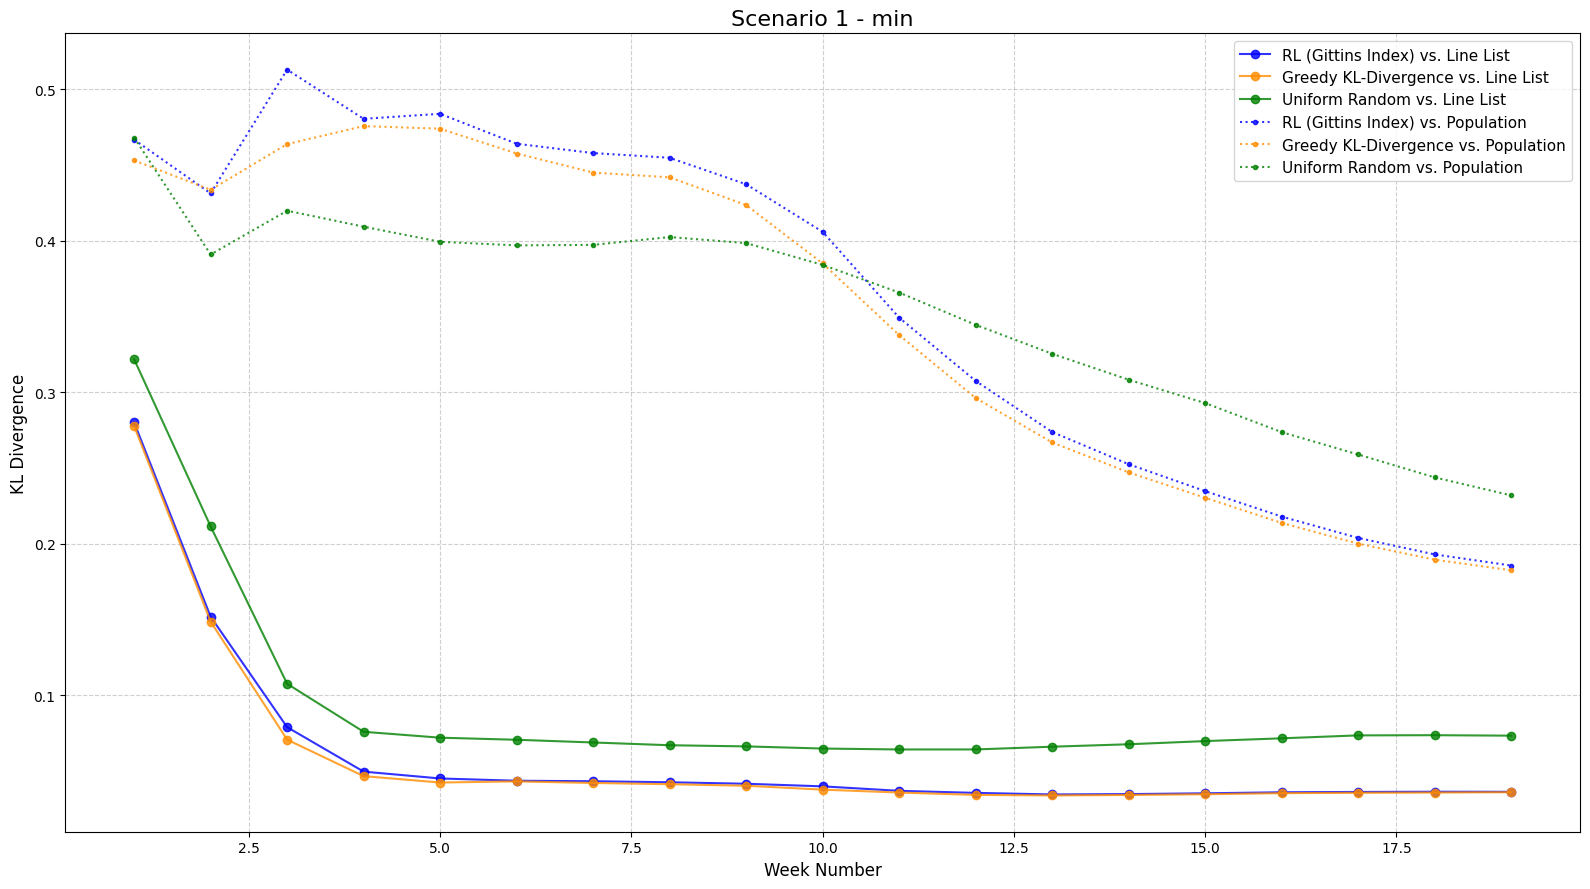

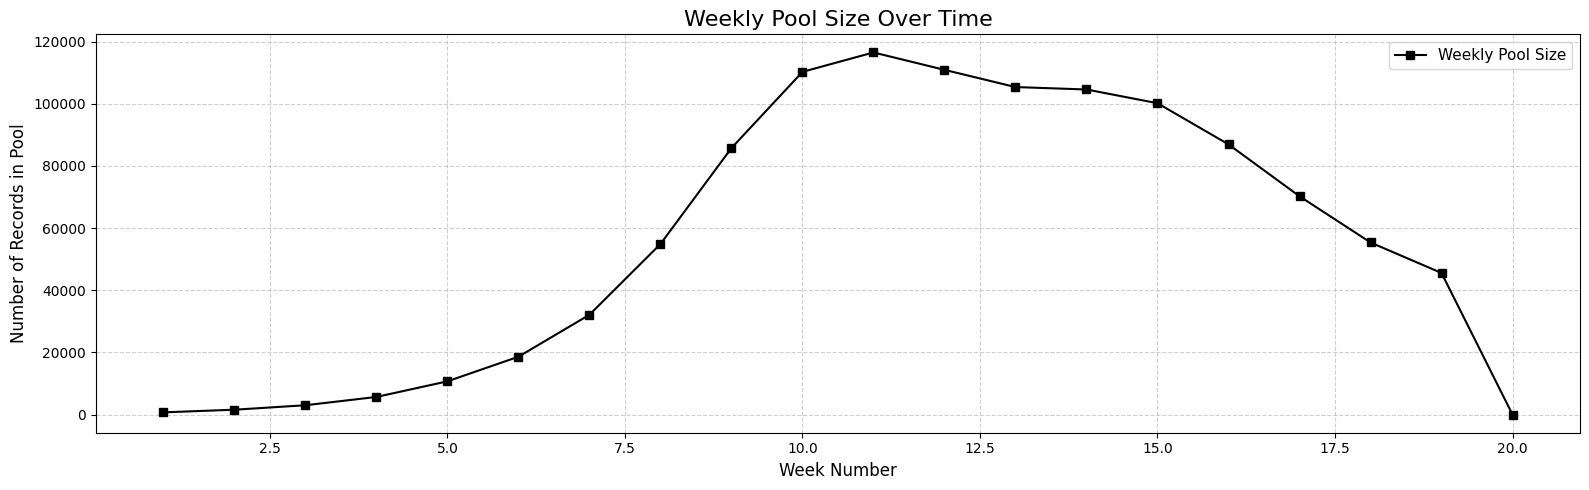

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time
import networkx as nx
from collections import defaultdict

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_minimal_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 50
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes needed in these functions
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION (CORRECTED)
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}

# --- Initialize data stores outside the loop ---
results_history = {}
cumulative_transfer_rates = {}
weekly_ground_truth_rates = [] # Store the true rate for each week
weekly_sampled_rates = {name: [] for name in algorithms} # Store each algo's rate
pool_size_history = []
BATCH_SIZE = 5000 

# This helper function assumes TICK is days from a known epoch, like the start of the simulation.
# You may need to adjust this based on how G_full was created.
SIMULATION_EPOCH = pd.to_datetime("2020-01-01") # Example epoch, adjust if needed
def get_date_from_node(node):
    try:
        tick = int(node.split('.')[1])
        return SIMULATION_EPOCH + timedelta(days=tick)
    except (IndexError, ValueError):
        return None

def calculate_cumulative_transfer_rate(pids, G_full, pid_stratum_map, pop_group_sizes):
    """
    Calculates the cumulative, normalized transfer rate for a given list of PIDs.
    This helper function is used both for the iterative samples and the ground truth.
    """
    pids_set = set(pids)
    nodes_of_interest = [n for n in G_full.nodes if n.split('.')[0] in pids_set]

    total_infections = defaultdict(int)
    for node in nodes_of_interest:
        infector_pid = node.split('.')[0]
        descendants = nx.descendants(G_full, node)
        total_infections[infector_pid] += len(descendants)

    if not total_infections:
        return pd.DataFrame(columns=['group', 'cumulative_transfer_rate'])

    df = pd.DataFrame(list(total_infections.items()), columns=['pid', 'total_infections'])
    df['group'] = df['pid'].map(pid_stratum_map)
    df.dropna(subset=['group'], inplace=True)

    infections_by_group = df.groupby('group')['total_infections'].sum().reset_index()
    infections_by_group['group_size'] = infections_by_group['group'].map(pop_group_sizes)
    infections_by_group['group_size'] = infections_by_group['group_size'].fillna(1).replace(0, 1)
    infections_by_group['cumulative_transfer_rate'] = infections_by_group['total_infections'] / infections_by_group['group_size']
    
    return infections_by_group[['group', 'cumulative_transfer_rate']]


# --- Initialize data stores for all simulation results ---
results_history = {}
# This new dictionary will store the list of rates over time for each algorithm
cumulative_rate_history = {}
pool_size_history = []
BATCH_SIZE = 5000

# --- Pre-compute maps and distributions for efficiency ---
pid_stratum_map = pop_df.set_index('pid')['group'].to_dict()
pop_group_sizes = pop_df['group'].value_counts().to_dict()

# --- Main simulation loop for each algorithm ---
for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()
    current_week = START_DATE
    
    # Initialize lists for this specific algorithm's run
    cumulative_linelist_dfs, weekly_sample_history = [], []
    cumulative_sampled_groups, cumulative_sampled_pids = [], []
    weekly_rate_values = [] # To store the calculated rate for each week
    pulls, rewards = {}, {}
    is_first_algorithm = (name == next(iter(algorithms)))
    
    # --- Weekly Simulation Loop ---
    while True:
        prev_mon = current_week - timedelta(days=7)
        prev_sun = current_week - timedelta(days=1)
        
        mask = (line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)
        week_df = line_df[mask]
        pool_size = len(week_df)

        # Only track pool size for the first algorithm run to avoid duplication
        if is_first_algorithm:
            pool_size_history.append(pool_size)
        
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for week of {current_week.date()} is {pool_size}, stopping.")
            break

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week of {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")
        
        cumulative_linelist_dfs.append(week_df)
        cumulative_linelist_pool = pd.concat(cumulative_linelist_dfs, ignore_index=True)
        target_dist = cumulative_linelist_pool['group'].value_counts(normalize=True).sort_index()

        # --- Run the sampling algorithm to get the weekly sample ---
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(week_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(week_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else: # Uniform
            sample_df = sampler_func(week_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        
        # --- Update histories with this week's results ---
        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        cumulative_sampled_pids.extend(sample_df['sim_pid'].tolist())

        # --- Calculate cumulative rate on all data sampled SO FAR ---
        # rate_df_so_far = calculate_cumulative_transfer_rate(
        #     cumulative_sampled_pids, G_full, pid_stratum_map, pop_group_sizes
        # )
        
        # Get a single value (the mean rate) to plot for this week
        # current_overall_rate = 0
        # if not rate_df_so_far.empty:
        #     current_overall_rate = rate_df_so_far['cumulative_transfer_rate'].mean()
        
        # weekly_rate_values.append(current_overall_rate)
        
        # --- Advance to the next week ---
        current_week += timedelta(weeks=1)

    # --- End of weekly loop for this algorithm ---
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- {name} finished in {elapsed_time:.2f} seconds ---")
    
    # Store the final histories for this algorithm
    results_history[name] = weekly_sample_history
    cumulative_rate_history[name] = weekly_rate_values

# -------------------------
# PLOTTING
# -------------------------
def plot_kl_vs_static_target(weekly_history, static_target_dist, label, color=None, linestyle=':'):
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    plt.plot(range(1, len(kl_values) + 1), kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_kl_vs_dynamic_target(weekly_sample_hist, weekly_linelist_hist, label, color=None, linestyle='-'):
    cumulative_sample_counts = pd.Series(dtype=float)
    cumulative_linelist_counts = pd.Series(dtype=float)
    kl_values = []
    num_weeks = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_hist[i], fill_value=0)
        cumulative_linelist_counts = cumulative_linelist_counts.add(weekly_linelist_hist[i], fill_value=0)
        cum_sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()
        cum_linelist_dist = cumulative_linelist_counts / cumulative_linelist_counts.sum()
        all_groups = cum_sample_dist.index.union(cum_linelist_dist.index)
        s_dist = cum_sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = cum_linelist_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    plt.plot(range(1, len(kl_values) + 1), kl_values, marker='o', linestyle=linestyle, label=label, color=color, alpha=0.8)

weekly_linelist_history = []
current_week = START_DATE
while True:
    prev_mon = current_week - timedelta(days=7)
    prev_sun = current_week - timedelta(days=1)
    mask = (line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)
    week_df = line_df[mask]
    if len(week_df) < MINIMUM_POOL_SIZE or (results_history and len(weekly_linelist_history) >= len(next(iter(results_history.values())))): break
    weekly_linelist_history.append(week_df['group'].value_counts())
    current_week += timedelta(weeks=1)

plt.figure(figsize=(16, 9))
plt.title("Scenario 1 - min", fontsize=16)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}
if results_history:
    for name, weekly_history in results_history.items():
        plot_kl_vs_dynamic_target(weekly_history, weekly_linelist_history, label=f"{name} vs. Line List", color=colors[name], linestyle='-')
    for name, weekly_history in results_history.items():
        plot_kl_vs_static_target(weekly_history, POP_DIST_STATIC, label=f"{name} vs. Population", color=colors[name], linestyle=':')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 2: Weekly Pool Size ---
plt.figure(figsize=(16, 5))
plt.title("Weekly Pool Size Over Time", fontsize=16)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Number of Records in Pool", fontsize=12)
plt.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='Weekly Pool Size')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [2]:
# --- Compute and Print Average KL Divergence Over Time for Each Algorithm ---
def compute_average_kl(weekly_sample_history, weekly_linelist_history):
    cumulative_sample_counts = pd.Series(dtype=float)
    cumulative_linelist_counts = pd.Series(dtype=float)
    kl_values = []
    num_weeks = min(len(weekly_sample_history), len(weekly_linelist_history))
    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_history[i], fill_value=0)
        cumulative_linelist_counts = cumulative_linelist_counts.add(weekly_linelist_history[i], fill_value=0)
        cum_sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()
        cum_linelist_dist = cumulative_linelist_counts / cumulative_linelist_counts.sum()
        all_groups = cum_sample_dist.index.union(cum_linelist_dist.index)
        s_dist = cum_sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = cum_linelist_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    return np.mean(kl_values)

# --- Print average KL for each algorithm ---
print("\nAverage KL-Divergence vs Dynamic Line List Target Distribution:")
for name, weekly_history in results_history.items():
    avg_kl = compute_average_kl(weekly_history, weekly_linelist_history)
    print(f"{name}: {avg_kl:.4f}")



Average KL-Divergence vs Dynamic Line List Target Distribution:
RL (Gittins Index): 0.0598
Greedy KL-Divergence: 0.0581
Uniform Random: 0.0920


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time
import networkx as nx
from collections import defaultdict

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_maximum_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 50
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes needed in these functions
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION (CORRECTED)
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}

# --- Initialize data stores outside the loop ---
results_history = {}
cumulative_transfer_rates = {}
weekly_ground_truth_rates = [] # Store the true rate for each week
weekly_sampled_rates = {name: [] for name in algorithms} # Store each algo's rate
pool_size_history = []
BATCH_SIZE = 5000 

# This helper function assumes TICK is days from a known epoch, like the start of the simulation.
# You may need to adjust this based on how G_full was created.
SIMULATION_EPOCH = pd.to_datetime("2020-01-01") # Example epoch, adjust if needed
def get_date_from_node(node):
    try:
        tick = int(node.split('.')[1])
        return SIMULATION_EPOCH + timedelta(days=tick)
    except (IndexError, ValueError):
        return None

def calculate_cumulative_transfer_rate(pids, G_full, pid_stratum_map, pop_group_sizes):
    """
    Calculates the cumulative, normalized transfer rate for a given list of PIDs.
    This helper function is used both for the iterative samples and the ground truth.
    """
    pids_set = set(pids)
    nodes_of_interest = [n for n in G_full.nodes if n.split('.')[0] in pids_set]

    total_infections = defaultdict(int)
    for node in nodes_of_interest:
        infector_pid = node.split('.')[0]
        descendants = nx.descendants(G_full, node)
        total_infections[infector_pid] += len(descendants)

    if not total_infections:
        return pd.DataFrame(columns=['group', 'cumulative_transfer_rate'])

    df = pd.DataFrame(list(total_infections.items()), columns=['pid', 'total_infections'])
    df['group'] = df['pid'].map(pid_stratum_map)
    df.dropna(subset=['group'], inplace=True)

    infections_by_group = df.groupby('group')['total_infections'].sum().reset_index()
    infections_by_group['group_size'] = infections_by_group['group'].map(pop_group_sizes)
    infections_by_group['group_size'] = infections_by_group['group_size'].fillna(1).replace(0, 1)
    infections_by_group['cumulative_transfer_rate'] = infections_by_group['total_infections'] / infections_by_group['group_size']
    
    return infections_by_group[['group', 'cumulative_transfer_rate']]


# --- Initialize data stores for all simulation results ---
results_history = {}
# This new dictionary will store the list of rates over time for each algorithm
cumulative_rate_history = {}
pool_size_history = []
BATCH_SIZE = 5000

# --- Pre-compute maps and distributions for efficiency ---
pid_stratum_map = pop_df.set_index('pid')['group'].to_dict()
pop_group_sizes = pop_df['group'].value_counts().to_dict()

# --- Main simulation loop for each algorithm ---
for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()
    current_week = START_DATE
    
    # Initialize lists for this specific algorithm's run
    cumulative_linelist_dfs, weekly_sample_history = [], []
    cumulative_sampled_groups, cumulative_sampled_pids = [], []
    weekly_rate_values = [] # To store the calculated rate for each week
    pulls, rewards = {}, {}
    is_first_algorithm = (name == next(iter(algorithms)))
    
    # --- Weekly Simulation Loop ---
    while True:
        prev_mon = current_week - timedelta(days=7)
        prev_sun = current_week - timedelta(days=1)
        
        mask = (line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)
        week_df = line_df[mask]
        pool_size = len(week_df)

        # Only track pool size for the first algorithm run to avoid duplication
        if is_first_algorithm:
            pool_size_history.append(pool_size)
        
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for week of {current_week.date()} is {pool_size}, stopping.")
            break

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week of {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")
        
        cumulative_linelist_dfs.append(week_df)
        cumulative_linelist_pool = pd.concat(cumulative_linelist_dfs, ignore_index=True)
        target_dist = cumulative_linelist_pool['group'].value_counts(normalize=True).sort_index()

        # --- Run the sampling algorithm to get the weekly sample ---
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(week_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(week_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else: # Uniform
            sample_df = sampler_func(week_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        
        # --- Update histories with this week's results ---
        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        cumulative_sampled_pids.extend(sample_df['sim_pid'].tolist())

        # --- Calculate cumulative rate on all data sampled SO FAR ---
        # rate_df_so_far = calculate_cumulative_transfer_rate(
        #     cumulative_sampled_pids, G_full, pid_stratum_map, pop_group_sizes
        # )
        
        # Get a single value (the mean rate) to plot for this week
        # current_overall_rate = 0
        # if not rate_df_so_far.empty:
        #     current_overall_rate = rate_df_so_far['cumulative_transfer_rate'].mean()
        
        # weekly_rate_values.append(current_overall_rate)
        
        # --- Advance to the next week ---
        current_week += timedelta(weeks=1)

    # --- End of weekly loop for this algorithm ---
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- {name} finished in {elapsed_time:.2f} seconds ---")
    
    # Store the final histories for this algorithm
    results_history[name] = weekly_sample_history
    cumulative_rate_history[name] = weekly_rate_values

# -------------------------
# PLOTTING
# -------------------------
def plot_kl_vs_static_target(weekly_history, static_target_dist, label, color=None, linestyle=':'):
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    plt.plot(range(1, len(kl_values) + 1), kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_kl_vs_dynamic_target(weekly_sample_hist, weekly_linelist_hist, label, color=None, linestyle='-'):
    cumulative_sample_counts = pd.Series(dtype=float)
    cumulative_linelist_counts = pd.Series(dtype=float)
    kl_values = []
    num_weeks = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_hist[i], fill_value=0)
        cumulative_linelist_counts = cumulative_linelist_counts.add(weekly_linelist_hist[i], fill_value=0)
        cum_sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()
        cum_linelist_dist = cumulative_linelist_counts / cumulative_linelist_counts.sum()
        all_groups = cum_sample_dist.index.union(cum_linelist_dist.index)
        s_dist = cum_sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = cum_linelist_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    plt.plot(range(1, len(kl_values) + 1), kl_values, marker='o', linestyle=linestyle, label=label, color=color, alpha=0.8)

weekly_linelist_history = []
current_week = START_DATE
while True:
    prev_mon = current_week - timedelta(days=7)
    prev_sun = current_week - timedelta(days=1)
    mask = (line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)
    week_df = line_df[mask]
    if len(week_df) < MINIMUM_POOL_SIZE or (results_history and len(weekly_linelist_history) >= len(next(iter(results_history.values())))): break
    weekly_linelist_history.append(week_df['group'].value_counts())
    current_week += timedelta(weeks=1)



Running Simulation for: RL (Gittins Index)
Week of 2021-05-31: Pool Size = 335, Dynamic Budget = 83
Week of 2021-06-07: Pool Size = 758, Dynamic Budget = 189
Week of 2021-06-14: Pool Size = 1576, Dynamic Budget = 394
Week of 2021-06-21: Pool Size = 2942, Dynamic Budget = 735
Week of 2021-06-28: Pool Size = 5313, Dynamic Budget = 1000
Week of 2021-07-05: Pool Size = 9408, Dynamic Budget = 1000
Week of 2021-07-12: Pool Size = 16541, Dynamic Budget = 1000
Week of 2021-07-19: Pool Size = 28940, Dynamic Budget = 1000
Week of 2021-07-26: Pool Size = 46243, Dynamic Budget = 1000
Week of 2021-08-02: Pool Size = 62145, Dynamic Budget = 1000
Week of 2021-08-09: Pool Size = 69331, Dynamic Budget = 1000
Week of 2021-08-16: Pool Size = 67239, Dynamic Budget = 1000
Week of 2021-08-23: Pool Size = 63048, Dynamic Budget = 1000
Week of 2021-08-30: Pool Size = 59395, Dynamic Budget = 1000
Week of 2021-09-06: Pool Size = 56589, Dynamic Budget = 1000
Week of 2021-09-13: Pool Size = 50566, Dynamic Budget 

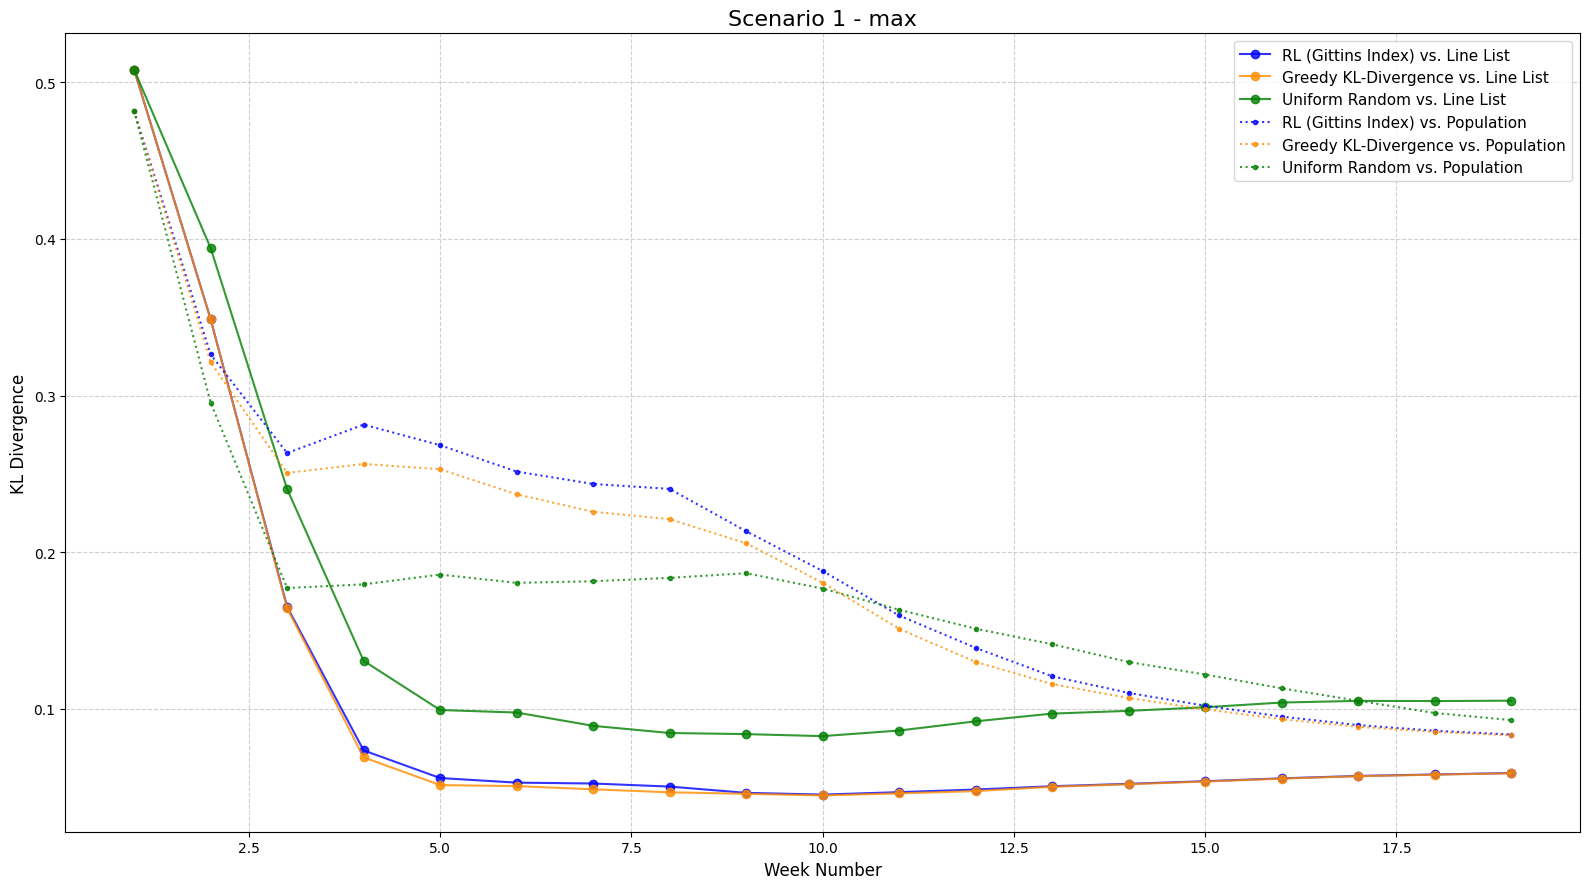

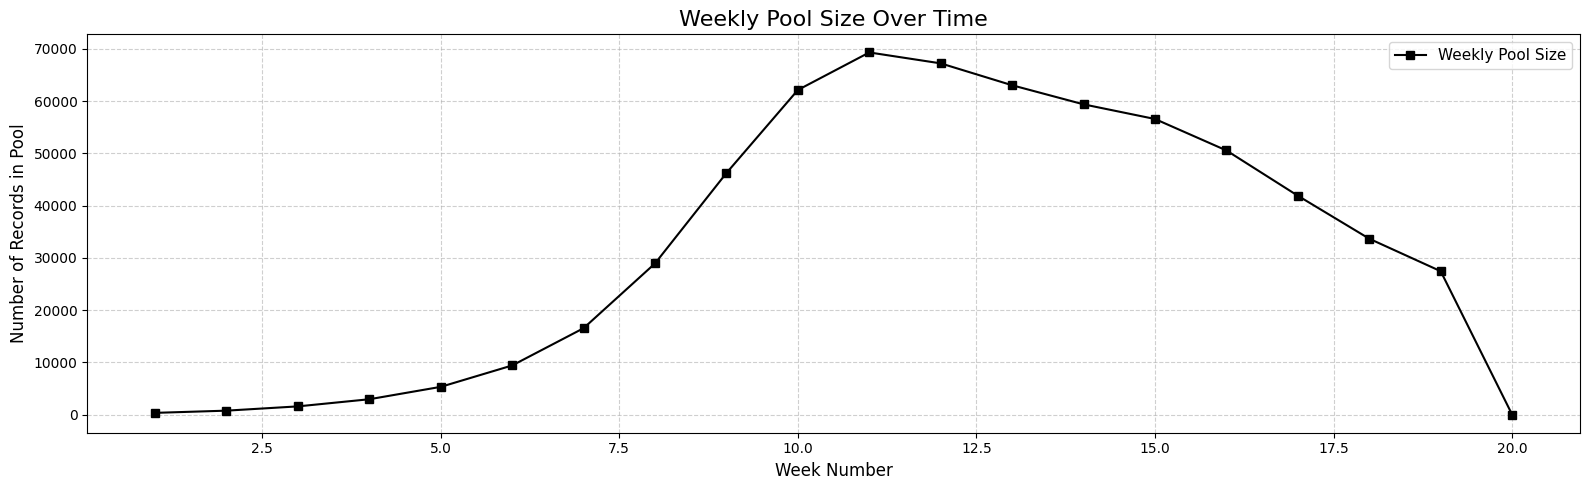

In [4]:
plt.figure(figsize=(16, 9))
plt.title("Scenario 1 - max", fontsize=16)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}
if results_history:
    for name, weekly_history in results_history.items():
        plot_kl_vs_dynamic_target(weekly_history, weekly_linelist_history, label=f"{name} vs. Line List", color=colors[name], linestyle='-')
    for name, weekly_history in results_history.items():
        plot_kl_vs_static_target(weekly_history, POP_DIST_STATIC, label=f"{name} vs. Population", color=colors[name], linestyle=':')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 2: Weekly Pool Size ---
plt.figure(figsize=(16, 5))
plt.title("Weekly Pool Size Over Time", fontsize=16)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Number of Records in Pool", fontsize=12)
plt.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='Weekly Pool Size')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [5]:
# --- Compute and Print Average KL Divergence Over Time for Each Algorithm ---
def compute_average_kl(weekly_sample_history, weekly_linelist_history):
    cumulative_sample_counts = pd.Series(dtype=float)
    cumulative_linelist_counts = pd.Series(dtype=float)
    kl_values = []
    num_weeks = min(len(weekly_sample_history), len(weekly_linelist_history))
    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_history[i], fill_value=0)
        cumulative_linelist_counts = cumulative_linelist_counts.add(weekly_linelist_history[i], fill_value=0)
        cum_sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()
        cum_linelist_dist = cumulative_linelist_counts / cumulative_linelist_counts.sum()
        all_groups = cum_sample_dist.index.union(cum_linelist_dist.index)
        s_dist = cum_sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = cum_linelist_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    return np.mean(kl_values)

# --- Print average KL for each algorithm ---
print("\nAverage KL-Divergence vs Dynamic Line List Target Distribution:")
for name, weekly_history in results_history.items():
    avg_kl = compute_average_kl(weekly_history, weekly_linelist_history)
    print(f"{name}: {avg_kl:.4f}")



Average KL-Divergence vs Dynamic Line List Target Distribution:
RL (Gittins Index): 0.0989
Greedy KL-Divergence: 0.0976
Uniform Random: 0.1423


# Scenario 2

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_minimal_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_dist = pd.Series(sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index:
                    best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_groups = sampled_this_week_groups + [g]
            trial_dist = pd.Series(trial_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl:
                best_group, best_kl = g, kl
        if best_group:
            sampled_this_week_groups.append(best_group)
            group_counts[best_group] -= 1
        else:
            break
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else:
        initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0:
        return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = []
    pulls, rewards = {}, {}

    while True:
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        target_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()
        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        sampled_groups = []
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        
        weekly_sample_history.append(sample_df['group'].value_counts())
        current_week += timedelta(weeks=1)

    end_time = time.time()
    print(f"--- {name} finished in {end_time - start_time:.2f} seconds ---")
    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history
    }



Running Simulation for: RL (Gittins Index)
Week 2021-05-31: Pool Size = 1327, Dynamic Budget = 331
Week 2021-06-07: Pool Size = 2914, Dynamic Budget = 728
Week 2021-06-14: Pool Size = 5911, Dynamic Budget = 1000
Week 2021-06-21: Pool Size = 11498, Dynamic Budget = 1000
Week 2021-06-28: Pool Size = 21469, Dynamic Budget = 1000
Week 2021-07-05: Pool Size = 38633, Dynamic Budget = 1000
Week 2021-07-12: Pool Size = 67554, Dynamic Budget = 1000
Week 2021-07-19: Pool Size = 115799, Dynamic Budget = 1000
Week 2021-07-26: Pool Size = 187394, Dynamic Budget = 1000
Week 2021-08-02: Pool Size = 267574, Dynamic Budget = 1000
Week 2021-08-09: Pool Size = 328919, Dynamic Budget = 1000
Week 2021-08-16: Pool Size = 352831, Dynamic Budget = 1000
Week 2021-08-23: Pool Size = 348023, Dynamic Budget = 1000
Week 2021-08-30: Pool Size = 335512, Dynamic Budget = 1000
Week 2021-09-06: Pool Size = 323604, Dynamic Budget = 1000
Week 2021-09-13: Pool Size = 302729, Dynamic Budget = 1000
Week 2021-09-20: Pool Si

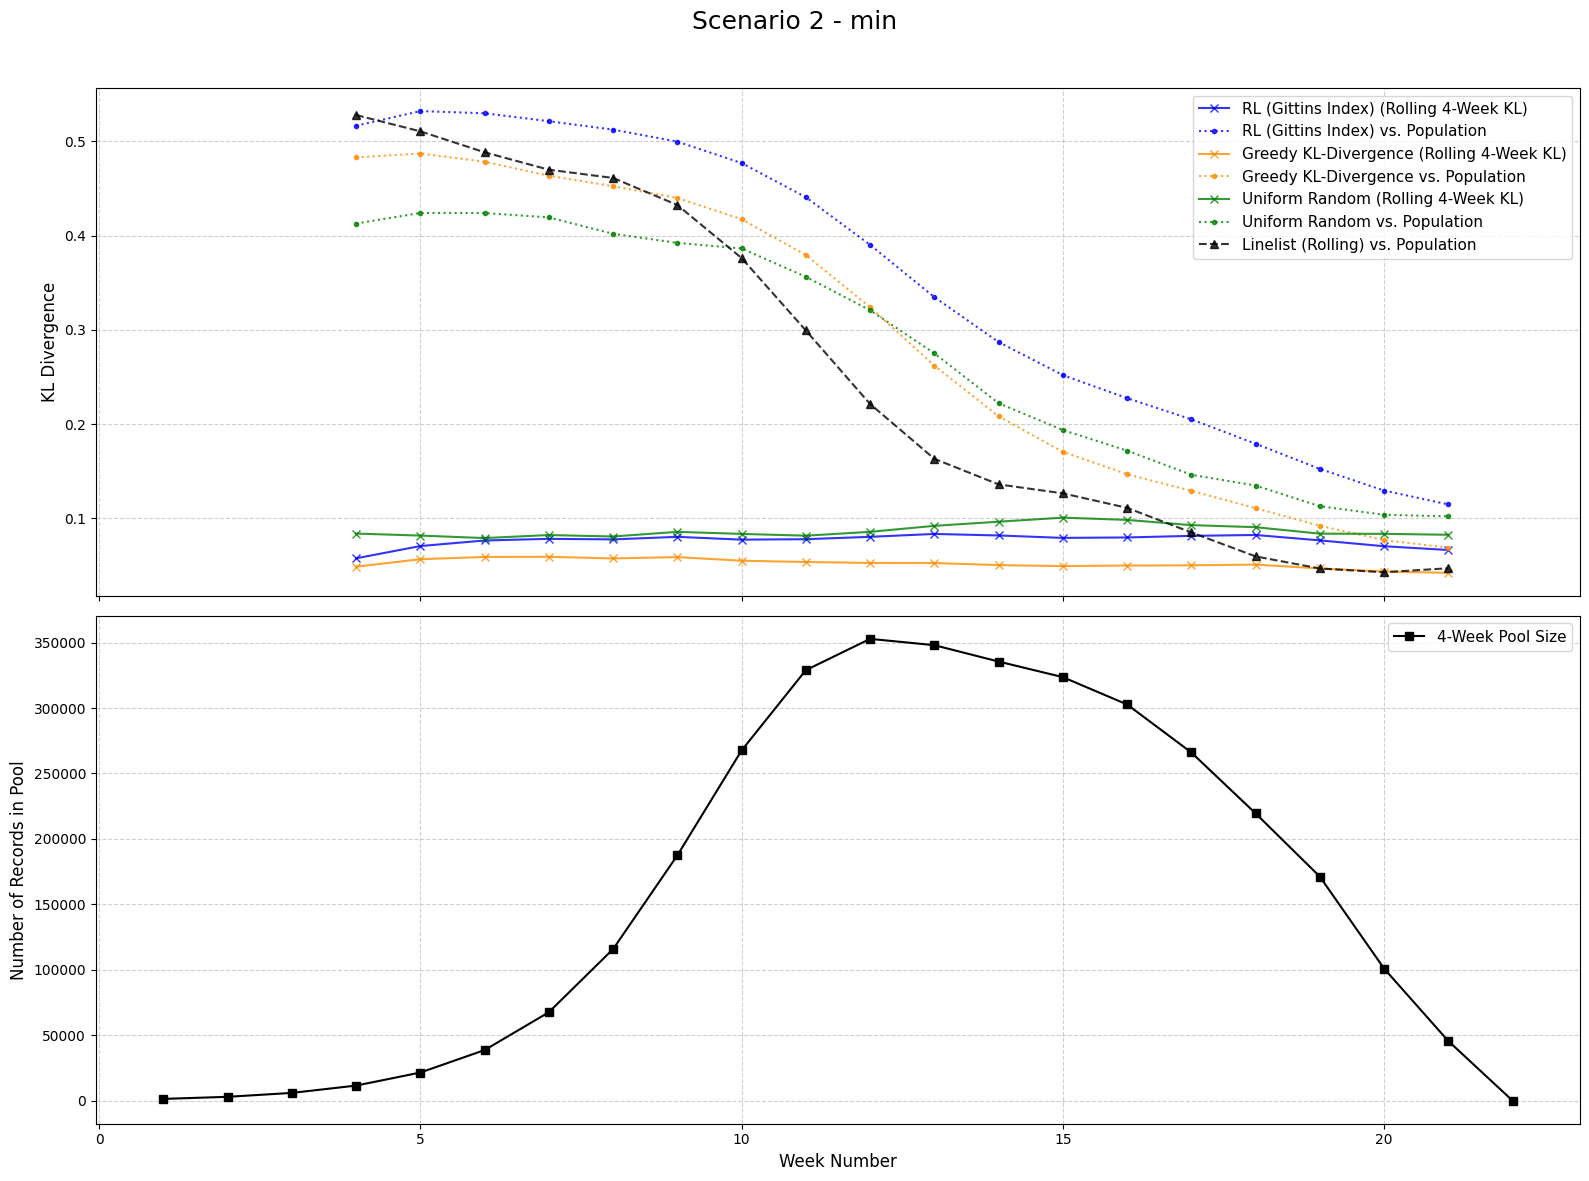


Average KL-Divergence (Rolling 4-Week Window):
RL (Gittins Index): 0.0767
Greedy KL-Divergence: 0.0522
Uniform Random: 0.0871


In [2]:
# -------------------------
# PLOTTING
# -------------------------

def plot_rolling_kl_vs_target(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    kl_values = []
    x_vals = []
    for i in range(3, len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break  # Target not available for this week

        rolling_samples = weekly_sample_hist[i-3:i+1]
        rolling_targets = weekly_target_dists[i]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue


        sample_dist = total_counts / total_counts.sum()

        all_groups = sample_dist.index.union(rolling_targets.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = rolling_targets.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)

    return kl_values


def plot_rolling_kl_vs_population(ax, weekly_sample_hist, static_target_dist, label, color=None, linestyle=':'):
    """KL divergence between rolling 4-week sample and static population."""
    kl_values = []
    x_vals = []

    for i in range(3, len(weekly_sample_hist)):
        rolling_samples = weekly_sample_hist[i-3:i+1]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue

        sample_dist = total_counts / total_counts.sum()
        all_groups = sample_dist.index.union(static_target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_rolling_linelist_vs_population(ax, weekly_target_dists, static_target_dist, label, color='gray', linestyle='--'):
    """Benchmark: KL divergence between rolling linelist (weeks t-3 to t) and static population distribution."""
    kl_values = []
    for i in range(3, len(weekly_target_dists)):
        linelist_dist = weekly_target_dists[i]
        all_groups = linelist_dist.index.union(static_target_dist.index)
        s_dist = linelist_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    x_vals = list(range(4, len(weekly_target_dists) + 1))
    ax.plot(x_vals, kl_values, marker='^', linestyle=linestyle, label=label, color=color, alpha=0.8)



fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle("Scenario 2 - min", fontsize=18)

ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}
average_kls = {}

if results_history:
    for name, history in results_history.items():
        kl_vals=plot_rolling_kl_vs_target(
            ax1, history['samples'], history['targets'],
            label=f"{name} (Rolling 4-Week KL)", color=colors[name], linestyle='-'
        )

        if kl_vals:
            average_kls[name] = np.mean(kl_vals)

        plot_rolling_kl_vs_population(
            ax1, history['samples'], POP_DIST_STATIC,
            label=f"{name} vs. Population", color=colors[name], linestyle=':'
        )

    plot_rolling_linelist_vs_population(
        ax1, next(iter(results_history.values()))['targets'], 
        POP_DIST_STATIC, 
        label="Linelist (Rolling) vs. Population", 
        color='black', linestyle='--'
    )


ax1.legend(fontsize=11)

ax2.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='4-Week Pool Size')
ax2.set_ylabel("Number of Records in Pool", fontsize=12)
ax2.set_xlabel("Week Number", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print average KL for each algorithm
print("\nAverage KL-Divergence (Rolling 4-Week Window):")
for name, avg in average_kls.items():
    print(f"{name}: {avg:.4f}")

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_maximum_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_dist = pd.Series(sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index:
                    best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_groups = sampled_this_week_groups + [g]
            trial_dist = pd.Series(trial_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl:
                best_group, best_kl = g, kl
        if best_group:
            sampled_this_week_groups.append(best_group)
            group_counts[best_group] -= 1
        else:
            break
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else:
        initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0:
        return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = []
    pulls, rewards = {}, {}

    while True:
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        target_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()
        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        sampled_groups = []
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        
        weekly_sample_history.append(sample_df['group'].value_counts())
        current_week += timedelta(weeks=1)

    end_time = time.time()
    print(f"--- {name} finished in {end_time - start_time:.2f} seconds ---")
    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history
    }



Running Simulation for: RL (Gittins Index)
Week 2021-05-31: Pool Size = 588, Dynamic Budget = 147
Week 2021-06-07: Pool Size = 1378, Dynamic Budget = 344
Week 2021-06-14: Pool Size = 3002, Dynamic Budget = 750
Week 2021-06-21: Pool Size = 5880, Dynamic Budget = 1000
Week 2021-06-28: Pool Size = 10916, Dynamic Budget = 1000
Week 2021-07-05: Pool Size = 19485, Dynamic Budget = 1000
Week 2021-07-12: Pool Size = 34463, Dynamic Budget = 1000
Week 2021-07-19: Pool Size = 60311, Dynamic Budget = 1000
Week 2021-07-26: Pool Size = 99887, Dynamic Budget = 1000
Week 2021-08-02: Pool Size = 146977, Dynamic Budget = 1000
Week 2021-08-09: Pool Size = 187662, Dynamic Budget = 1000
Week 2021-08-16: Pool Size = 207740, Dynamic Budget = 1000
Week 2021-08-23: Pool Size = 208332, Dynamic Budget = 1000
Week 2021-08-30: Pool Size = 197929, Dynamic Budget = 1000
Week 2021-09-06: Pool Size = 186714, Dynamic Budget = 1000
Week 2021-09-13: Pool Size = 172986, Dynamic Budget = 1000
Week 2021-09-20: Pool Size = 

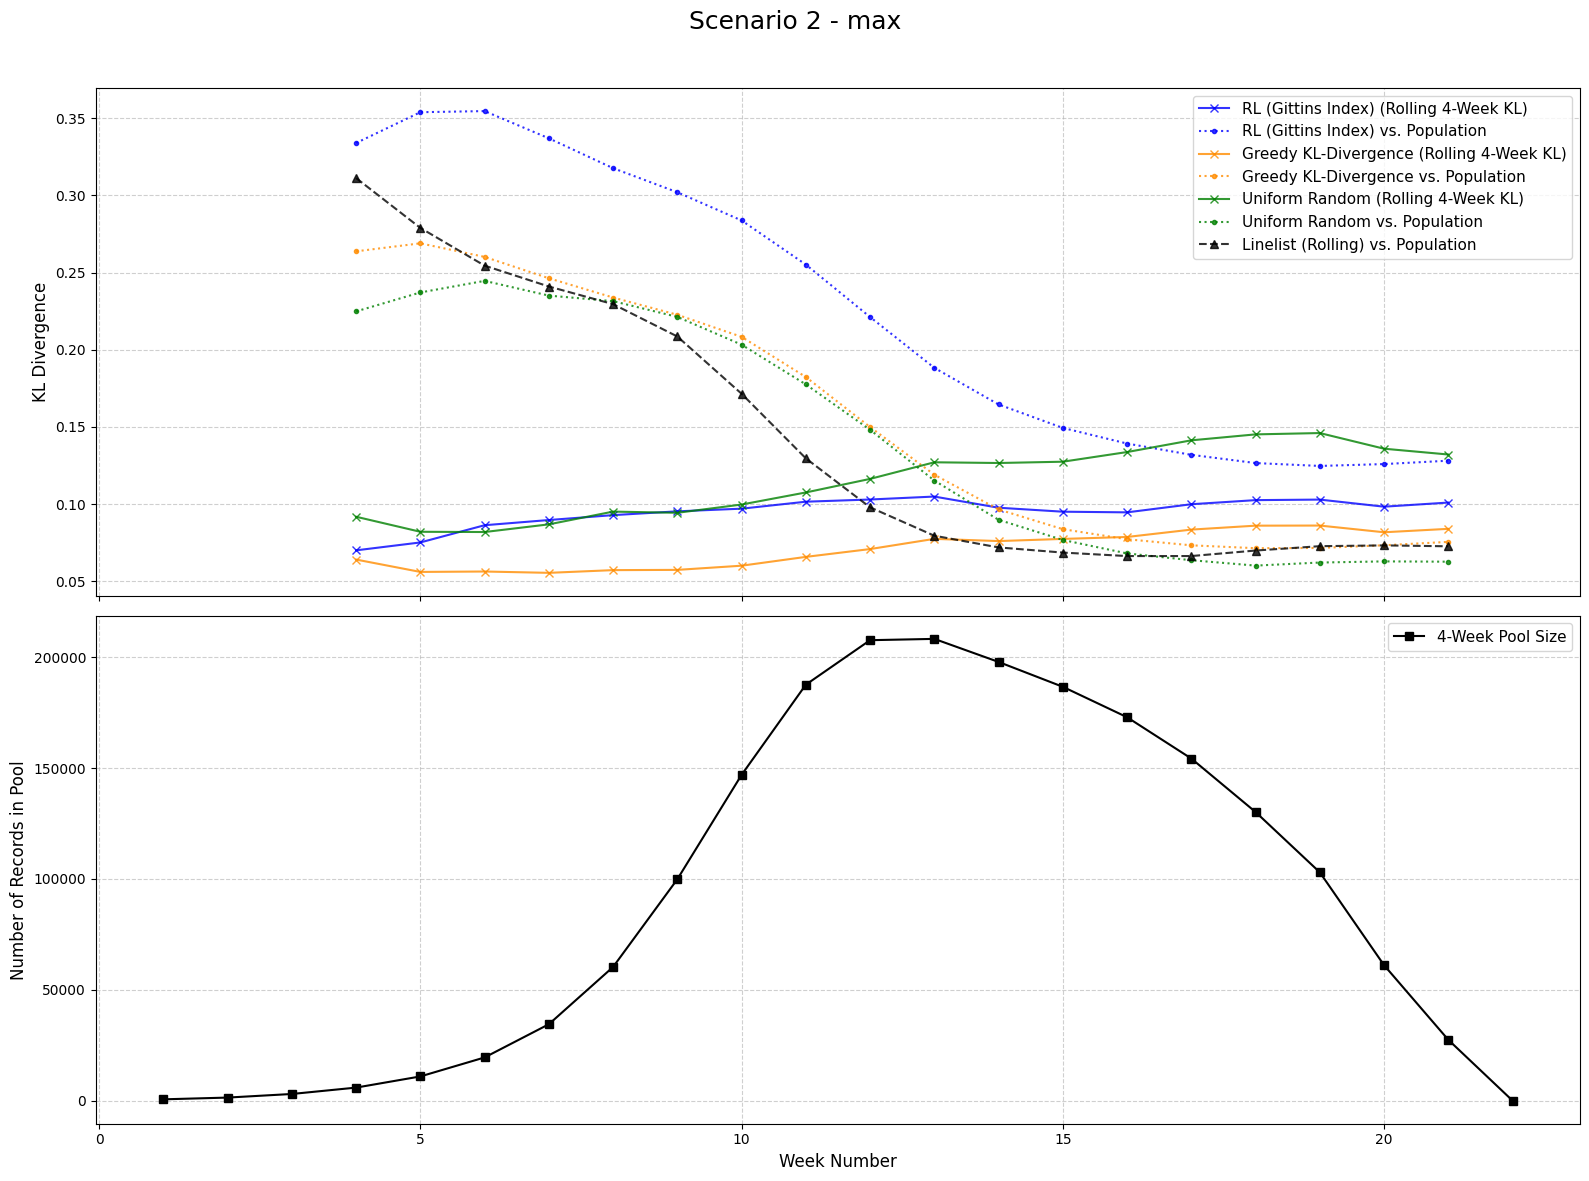


Average KL-Divergence (Rolling 4-Week Window):
RL (Gittins Index): 0.0949
Greedy KL-Divergence: 0.0708
Uniform Random: 0.1150


In [7]:
# -------------------------
# PLOTTING
# -------------------------

def plot_rolling_kl_vs_target(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    kl_values = []
    x_vals = []
    for i in range(3, len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break  # Target not available for this week

        rolling_samples = weekly_sample_hist[i-3:i+1]
        rolling_targets = weekly_target_dists[i]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue


        sample_dist = total_counts / total_counts.sum()

        all_groups = sample_dist.index.union(rolling_targets.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = rolling_targets.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)

    return kl_values


def plot_rolling_kl_vs_population(ax, weekly_sample_hist, static_target_dist, label, color=None, linestyle=':'):
    """KL divergence between rolling 4-week sample and static population."""
    kl_values = []
    x_vals = []

    for i in range(3, len(weekly_sample_hist)):
        rolling_samples = weekly_sample_hist[i-3:i+1]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue

        sample_dist = total_counts / total_counts.sum()
        all_groups = sample_dist.index.union(static_target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_rolling_linelist_vs_population(ax, weekly_target_dists, static_target_dist, label, color='gray', linestyle='--'):
    """Benchmark: KL divergence between rolling linelist (weeks t-3 to t) and static population distribution."""
    kl_values = []
    for i in range(3, len(weekly_target_dists)):
        linelist_dist = weekly_target_dists[i]
        all_groups = linelist_dist.index.union(static_target_dist.index)
        s_dist = linelist_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    x_vals = list(range(4, len(weekly_target_dists) + 1))
    ax.plot(x_vals, kl_values, marker='^', linestyle=linestyle, label=label, color=color, alpha=0.8)



fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle("Scenario 2 - max", fontsize=18)

ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}
average_kls = {}

if results_history:
    for name, history in results_history.items():
        kl_vals=plot_rolling_kl_vs_target(
            ax1, history['samples'], history['targets'],
            label=f"{name} (Rolling 4-Week KL)", color=colors[name], linestyle='-'
        )

        if kl_vals:
            average_kls[name] = np.mean(kl_vals)

        plot_rolling_kl_vs_population(
            ax1, history['samples'], POP_DIST_STATIC,
            label=f"{name} vs. Population", color=colors[name], linestyle=':'
        )

    plot_rolling_linelist_vs_population(
        ax1, next(iter(results_history.values()))['targets'], 
        POP_DIST_STATIC, 
        label="Linelist (Rolling) vs. Population", 
        color='black', linestyle='--'
    )


ax1.legend(fontsize=11)

ax2.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='4-Week Pool Size')
ax2.set_ylabel("Number of Records in Pool", fontsize=12)
ax2.set_xlabel("Week Number", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print average KL for each algorithm
print("\nAverage KL-Divergence (Rolling 4-Week Window):")
for name, avg in average_kls.items():
    print(f"{name}: {avg:.4f}")

# Scenario 3

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_minimal_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes were needed in these functions.
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION (TARGET: ROLLING 4-WEEK WINDOW)
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = [] # Store the target distribution for each week
    cumulative_sampled_groups = []
    pulls, rewards = {}, {}

    while True:
        # --- MODIFICATION START ---
        # Define rolling 4-week window for the pool and target
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        # Calculate the target distribution from the rolling window
        target_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()
        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Period ending {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        # Sample from the rolling window
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        # --- MODIFICATION END ---

        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        current_week += timedelta(weeks=1)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- {name} finished in {elapsed_time:.2f} seconds ---")

    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history
    }



Running Simulation for: RL (Gittins Index)
Period ending 2021-05-31: Pool Size = 1327, Dynamic Budget = 331
Period ending 2021-06-07: Pool Size = 2914, Dynamic Budget = 728
Period ending 2021-06-14: Pool Size = 5911, Dynamic Budget = 1000
Period ending 2021-06-21: Pool Size = 11498, Dynamic Budget = 1000
Period ending 2021-06-28: Pool Size = 21469, Dynamic Budget = 1000
Period ending 2021-07-05: Pool Size = 38633, Dynamic Budget = 1000
Period ending 2021-07-12: Pool Size = 67554, Dynamic Budget = 1000
Period ending 2021-07-19: Pool Size = 115799, Dynamic Budget = 1000
Period ending 2021-07-26: Pool Size = 187394, Dynamic Budget = 1000
Period ending 2021-08-02: Pool Size = 267574, Dynamic Budget = 1000
Period ending 2021-08-09: Pool Size = 328919, Dynamic Budget = 1000
Period ending 2021-08-16: Pool Size = 352831, Dynamic Budget = 1000
Period ending 2021-08-23: Pool Size = 348023, Dynamic Budget = 1000
Period ending 2021-08-30: Pool Size = 335512, Dynamic Budget = 1000
Period ending 20

RL (Gittins Index) - Average KL (Cumulative vs. Rolling Target): 0.0520
Greedy KL-Divergence - Average KL (Cumulative vs. Rolling Target): 0.0511
Uniform Random - Average KL (Cumulative vs. Rolling Target): 0.1029


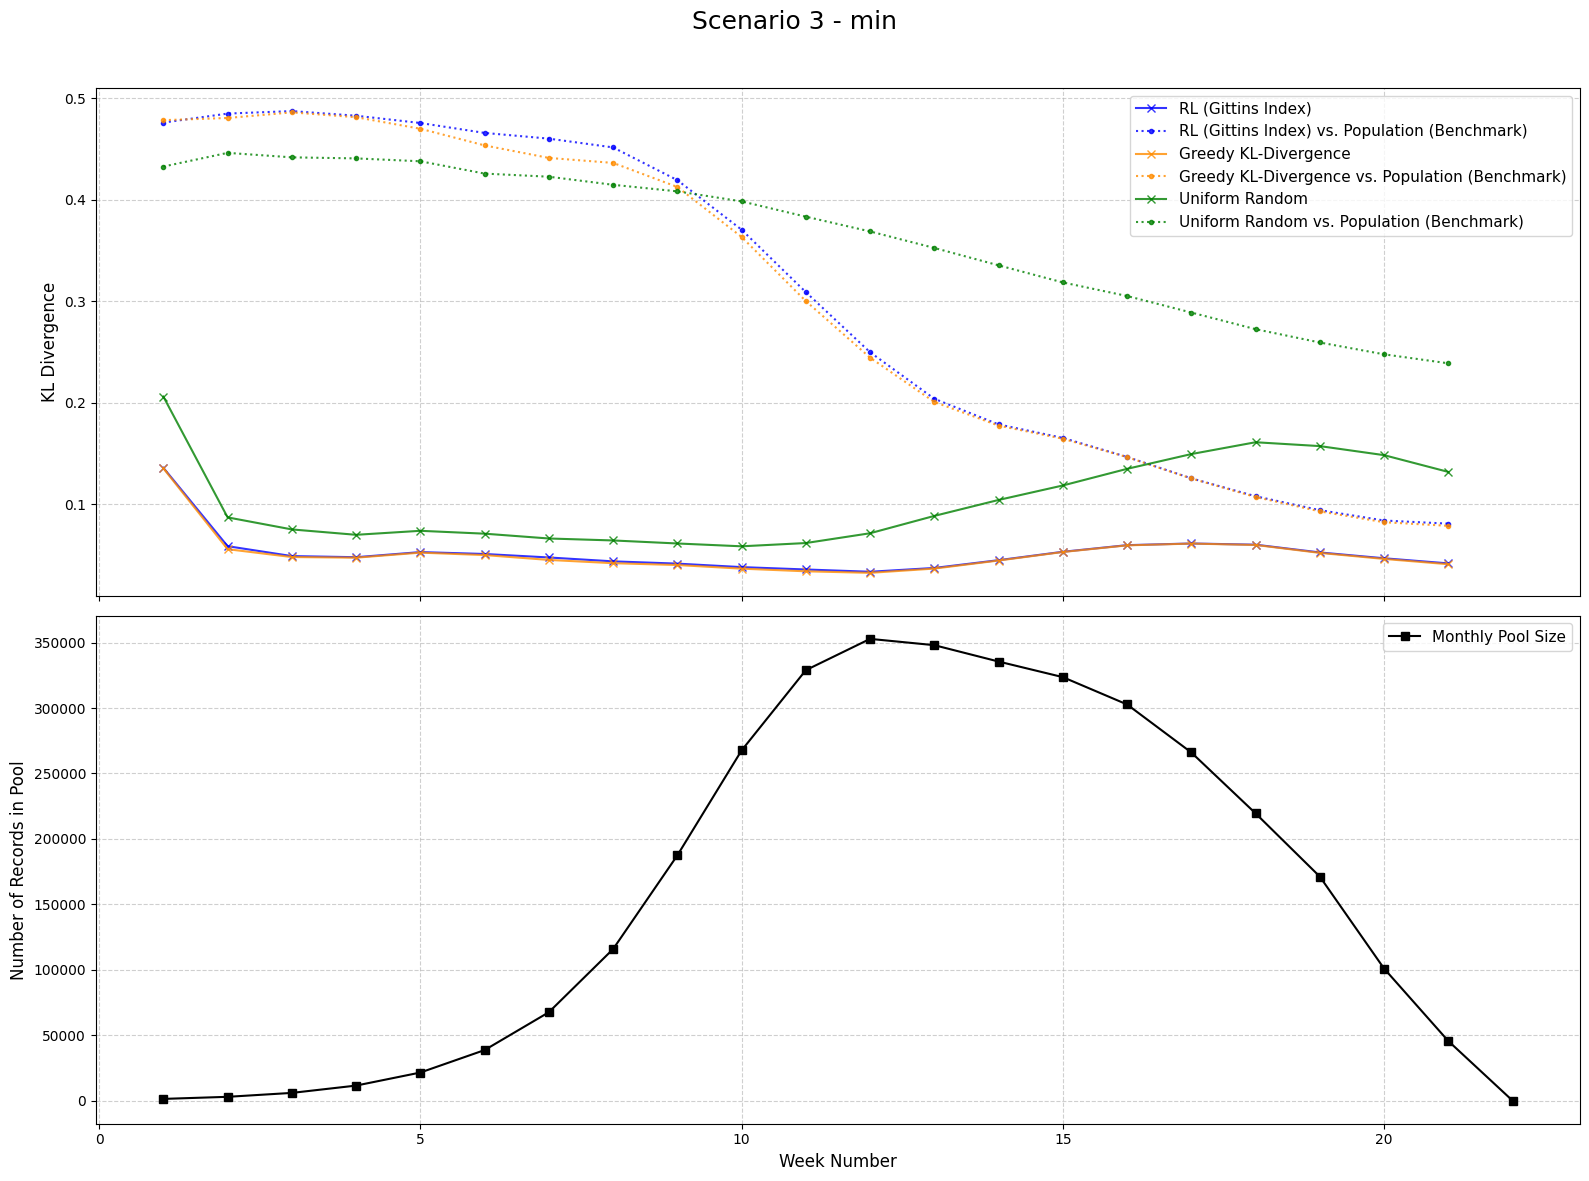

In [2]:
# -------------------------
# PLOTTING
# -------------------------

def plot_cumulative_vs_rolling_target_kl(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    x_vals = []

    for i in range(len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break

        # Update cumulative distribution
        cumulative_counts = cumulative_counts.add(weekly_sample_hist[i], fill_value=0)
        if cumulative_counts.sum() == 0 or weekly_target_dists[i].sum() == 0:
            continue

        sample_dist = cumulative_counts / cumulative_counts.sum()
        target_dist = weekly_target_dists[i]

        all_groups = sample_dist.index.union(target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)

    avg_kl = np.mean(kl_values) if kl_values else float('nan')
    print(f"{label} - Average KL (Cumulative vs. Rolling Target): {avg_kl:.4f}")

    return kl_values




def plot_kl_vs_static_target(ax, weekly_history, static_target_dist, label, color=None, linestyle=':'):
    """Calculates KL divergence between cumulative samples and a single static target."""
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    ax.plot(range(1, len(kl_values) + 1), kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

# --- Create two vertically stacked subplots that share an x-axis ---
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(16, 12), # Increased height to accommodate the second plot
    sharex=True      # This ensures the x-axes are aligned
)
fig.suptitle("Scenario 3 - min", fontsize=18)


# --- Plot 1: KL Divergence (on the top axis, ax1) ---
ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

if results_history:
    for name, history in results_history.items():
        # Pass ax1 to the plotting functions
        plot_cumulative_vs_rolling_target_kl(
            ax1, history['samples'], history['targets'],
            label=name, color=colors.get(name)
        )
        plot_kl_vs_static_target(
            ax1, history['samples'], POP_DIST_STATIC, 
            label=f"{name} vs. Population (Benchmark)", 
            color=colors[name], 
            linestyle=':'
        )
ax1.legend(fontsize=11)


# --- Plot 2: Pool Size (on the bottom axis, ax2) ---
ax2.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='Monthly Pool Size')
ax2.set_ylabel("Number of Records in Pool", fontsize=12)
ax2.set_xlabel("Week Number", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=11)

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the main title
plt.show()

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_maximum_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes were needed in these functions.
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION (TARGET: ROLLING 4-WEEK WINDOW)
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = [] # Store the target distribution for each week
    cumulative_sampled_groups = []
    pulls, rewards = {}, {}

    while True:
        # --- MODIFICATION START ---
        # Define rolling 4-week window for the pool and target
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        # Calculate the target distribution from the rolling window
        target_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()
        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Period ending {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        # Sample from the rolling window
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        # --- MODIFICATION END ---

        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        current_week += timedelta(weeks=1)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- {name} finished in {elapsed_time:.2f} seconds ---")

    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history
    }


Running Simulation for: RL (Gittins Index)
Period ending 2021-05-31: Pool Size = 588, Dynamic Budget = 147
Period ending 2021-06-07: Pool Size = 1378, Dynamic Budget = 344
Period ending 2021-06-14: Pool Size = 3002, Dynamic Budget = 750
Period ending 2021-06-21: Pool Size = 5880, Dynamic Budget = 1000
Period ending 2021-06-28: Pool Size = 10916, Dynamic Budget = 1000
Period ending 2021-07-05: Pool Size = 19485, Dynamic Budget = 1000
Period ending 2021-07-12: Pool Size = 34463, Dynamic Budget = 1000
Period ending 2021-07-19: Pool Size = 60311, Dynamic Budget = 1000
Period ending 2021-07-26: Pool Size = 99887, Dynamic Budget = 1000
Period ending 2021-08-02: Pool Size = 146977, Dynamic Budget = 1000
Period ending 2021-08-09: Pool Size = 187662, Dynamic Budget = 1000
Period ending 2021-08-16: Pool Size = 207740, Dynamic Budget = 1000
Period ending 2021-08-23: Pool Size = 208332, Dynamic Budget = 1000
Period ending 2021-08-30: Pool Size = 197929, Dynamic Budget = 1000
Period ending 2021-09

RL (Gittins Index) - Average KL (Cumulative vs. Rolling Target): 0.0942
Greedy KL-Divergence - Average KL (Cumulative vs. Rolling Target): 0.0924
Uniform Random - Average KL (Cumulative vs. Rolling Target): 0.1655


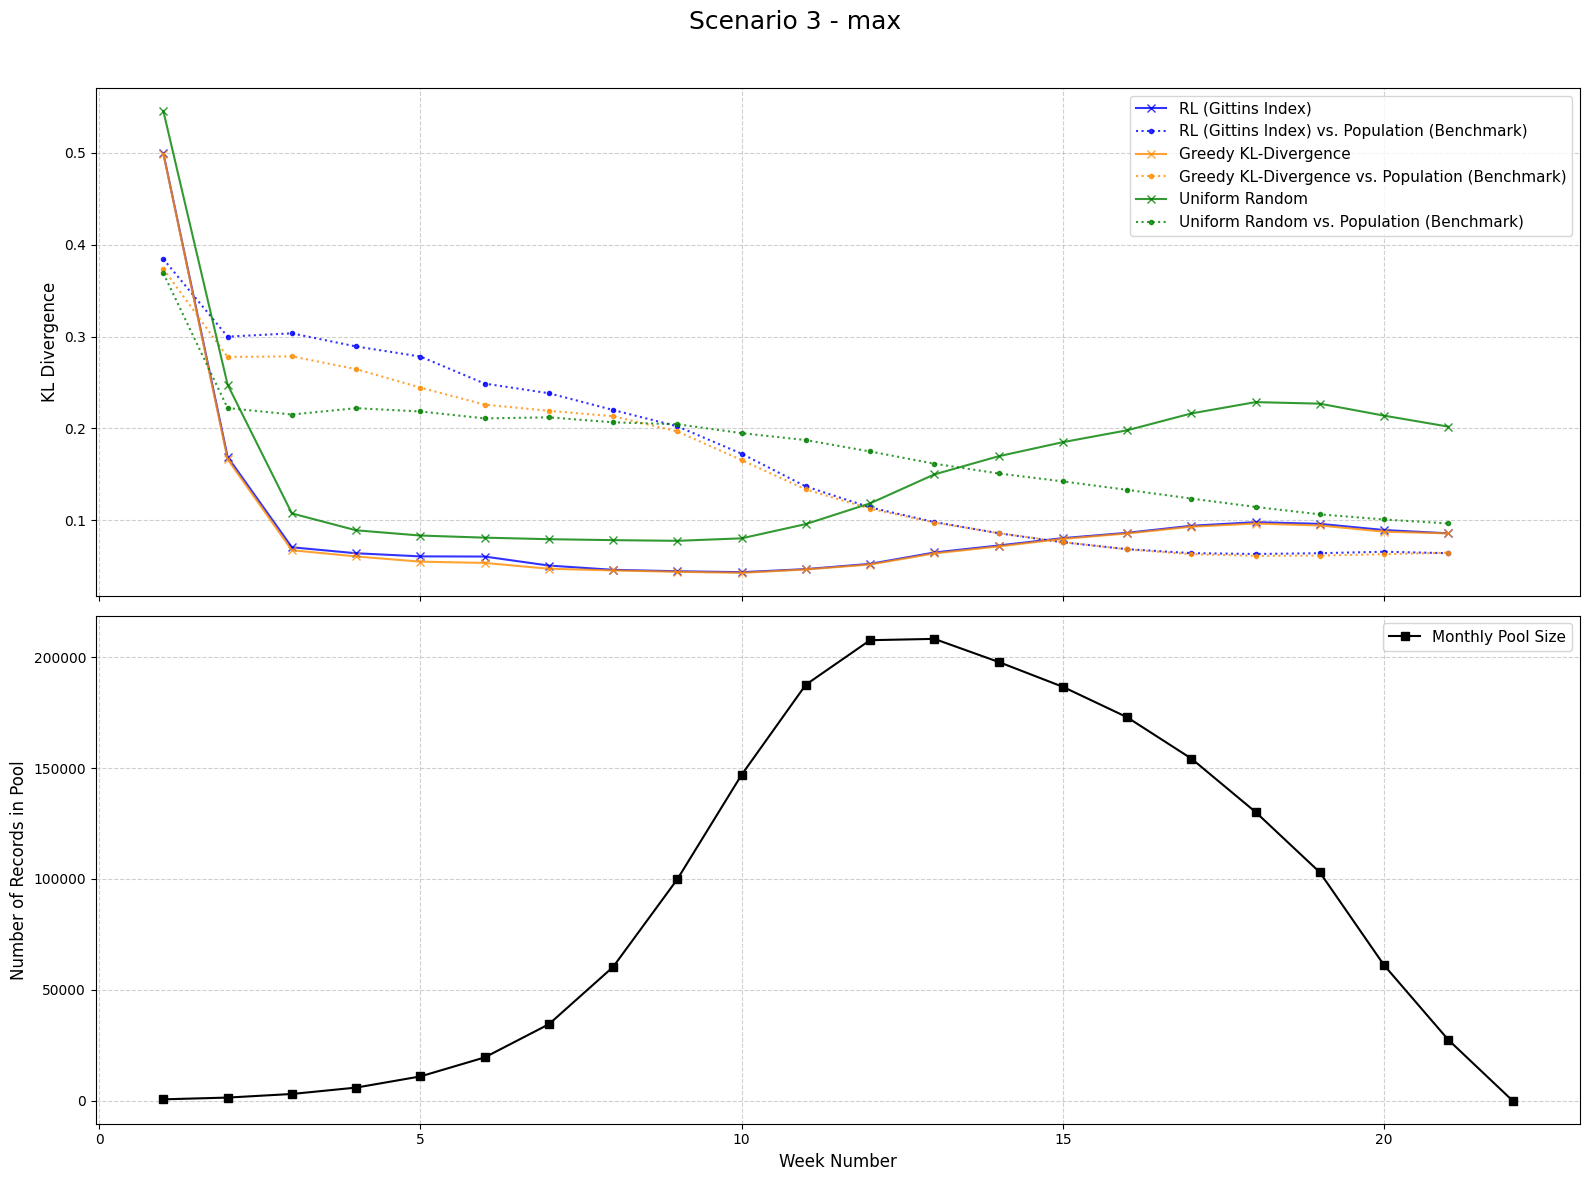

In [3]:
# -------------------------
# PLOTTING
# -------------------------

def plot_cumulative_vs_rolling_target_kl(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    x_vals = []

    for i in range(len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break

        # Update cumulative distribution
        cumulative_counts = cumulative_counts.add(weekly_sample_hist[i], fill_value=0)
        if cumulative_counts.sum() == 0 or weekly_target_dists[i].sum() == 0:
            continue

        sample_dist = cumulative_counts / cumulative_counts.sum()
        target_dist = weekly_target_dists[i]

        all_groups = sample_dist.index.union(target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)

    avg_kl = np.mean(kl_values) if kl_values else float('nan')
    print(f"{label} - Average KL (Cumulative vs. Rolling Target): {avg_kl:.4f}")

    return kl_values




def plot_kl_vs_static_target(ax, weekly_history, static_target_dist, label, color=None, linestyle=':'):
    """Calculates KL divergence between cumulative samples and a single static target."""
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    ax.plot(range(1, len(kl_values) + 1), kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

# --- Create two vertically stacked subplots that share an x-axis ---
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(16, 12), # Increased height to accommodate the second plot
    sharex=True      # This ensures the x-axes are aligned
)
fig.suptitle("Scenario 3 - max", fontsize=18)


# --- Plot 1: KL Divergence (on the top axis, ax1) ---
ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

if results_history:
    for name, history in results_history.items():
        # Pass ax1 to the plotting functions
        plot_cumulative_vs_rolling_target_kl(
            ax1, history['samples'], history['targets'],
            label=name, color=colors.get(name)
        )
        plot_kl_vs_static_target(
            ax1, history['samples'], POP_DIST_STATIC, 
            label=f"{name} vs. Population (Benchmark)", 
            color=colors[name], 
            linestyle=':'
        )
ax1.legend(fontsize=11)


# --- Plot 2: Pool Size (on the bottom axis, ax2) ---
ax2.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='Monthly Pool Size')
ax2.set_ylabel("Number of Records in Pool", fontsize=12)
ax2.set_xlabel("Week Number", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=11)

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the main title
plt.show()

# Scenario 4

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_minimal_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 50
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']
ALPHA_WEIGHT = 0.5

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes are needed in the algorithm functions themselves.
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)
# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
linelist_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()
    current_week = START_DATE
    cumulative_linelist_dfs, weekly_sample_history, cumulative_sampled_groups = [], [], []
    pulls, rewards = {}, {}
    while True:
        prev_mon = current_week - timedelta(days=7)
        prev_sun = current_week - timedelta(days=1)
        mask = (line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)
        week_df = line_df[mask]
        pool_size = len(week_df)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for week of {current_week.date()} is {pool_size}, stopping.")
            break
        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week of {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")
        cumulative_linelist_dfs.append(week_df)
        if name == list(algorithms.keys())[0]:
            linelist_history.append(week_df['group'].value_counts())
        cumulative_linelist_pool = pd.concat(cumulative_linelist_dfs, ignore_index=True)
        dynamic_linelist_dist = cumulative_linelist_pool['group'].value_counts(normalize=True)
        all_groups_index = POP_DIST_STATIC.index.union(dynamic_linelist_dist.index)
        pop_dist_aligned = POP_DIST_STATIC.reindex(all_groups_index, fill_value=0)
        linelist_dist_aligned = dynamic_linelist_dist.reindex(all_groups_index, fill_value=0)
        combined_target_dist = (ALPHA_WEIGHT * pop_dist_aligned) + ((1 - ALPHA_WEIGHT) * linelist_dist_aligned)
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(week_df, combined_target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(week_df, combined_target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else:
            sample_df = sampler_func(week_df, combined_target_dist, dynamic_batch_size, MIN_PER_GROUP)
        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        current_week += timedelta(weeks=1)
    end_time = time.time()
    print(f"--- {name} finished in {end_time - start_time:.2f} seconds ---")
    results_history[name] = weekly_sample_history


Running Simulation for: RL (Gittins Index)
Week of 2021-05-31: Pool Size = 728, Dynamic Budget = 182
Week of 2021-06-07: Pool Size = 1577, Dynamic Budget = 394
Week of 2021-06-14: Pool Size = 3015, Dynamic Budget = 753
Week of 2021-06-21: Pool Size = 5683, Dynamic Budget = 1000
Week of 2021-06-28: Pool Size = 10707, Dynamic Budget = 1000
Week of 2021-07-05: Pool Size = 18621, Dynamic Budget = 1000
Week of 2021-07-12: Pool Size = 32121, Dynamic Budget = 1000
Week of 2021-07-19: Pool Size = 54877, Dynamic Budget = 1000
Week of 2021-07-26: Pool Size = 85751, Dynamic Budget = 1000
Week of 2021-08-02: Pool Size = 110276, Dynamic Budget = 1000
Week of 2021-08-09: Pool Size = 116529, Dynamic Budget = 1000
Week of 2021-08-16: Pool Size = 110929, Dynamic Budget = 1000
Week of 2021-08-23: Pool Size = 105393, Dynamic Budget = 1000
Week of 2021-08-30: Pool Size = 104607, Dynamic Budget = 1000
Week of 2021-09-06: Pool Size = 100195, Dynamic Budget = 1000
Week of 2021-09-13: Pool Size = 86951, Dyna

RL (Gittins Index) - Average Mean KL (Population + Linelist): 0.1347
Greedy KL-Divergence - Average Mean KL (Population + Linelist): 0.1336
Uniform Random - Average Mean KL (Population + Linelist): 0.2191


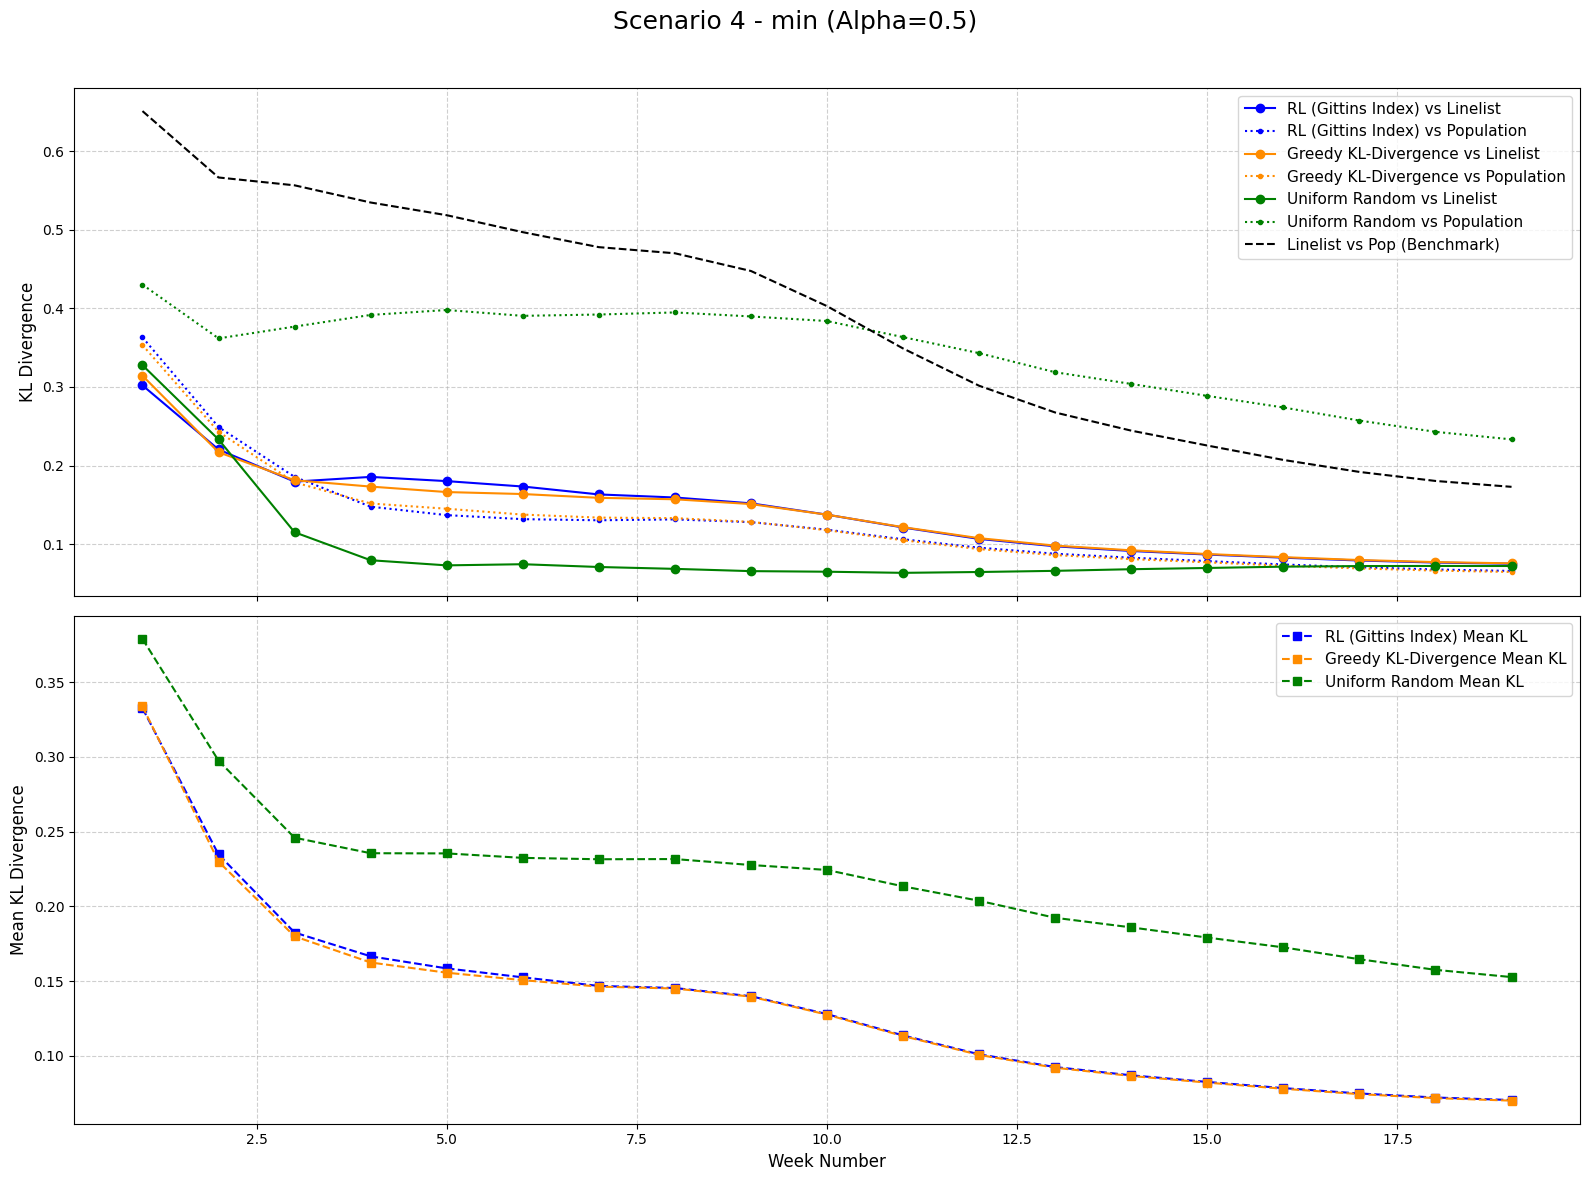

In [2]:
# -------------------------
# PLOTTING (Cumulative + Mean KL)
# -------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.suptitle(f"Scenario 4 - min (Alpha={ALPHA_WEIGHT})", fontsize=18)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

# --- ax1: KL vs Population and Linelist (Cumulative)
for name, sample_hist in results_history.items():
    cum_sample = pd.Series(dtype=float)
    cum_linelist = pd.Series(dtype=float)
    kl_pop_vals, kl_list_vals = [], []
    for i in range(len(sample_hist)):
        if i >= len(linelist_history): break
        cum_sample = cum_sample.add(sample_hist[i], fill_value=0)
        cum_linelist = cum_linelist.add(linelist_history[i], fill_value=0)
        sample_dist = cum_sample / cum_sample.sum()

        # KL vs Pop
        all_g = sample_dist.index.union(POP_DIST_STATIC.index)
        s = sample_dist.reindex(all_g, fill_value=1e-9)
        t = POP_DIST_STATIC.reindex(all_g, fill_value=1e-9)
        kl_pop_vals.append(entropy(s, t))

        # KL vs Linelist
        t2 = cum_linelist / cum_linelist.sum()
        all_g2 = sample_dist.index.union(t2.index)
        s2 = sample_dist.reindex(all_g2, fill_value=1e-9)
        t2 = t2.reindex(all_g2, fill_value=1e-9)
        kl_list_vals.append(entropy(s2, t2))

    ax1.plot(range(1, len(kl_list_vals)+1), kl_list_vals, label=f"{name} vs Linelist", linestyle='-', marker='o', color=colors[name])
    ax1.plot(range(1, len(kl_pop_vals)+1), kl_pop_vals, label=f"{name} vs Population", linestyle=':', marker='.', color=colors[name])

# KL of linelist vs population (benchmark)
cum_linelist = pd.Series(dtype=float)
benchmark_vals = []
for i in range(len(linelist_history)):
    cum_linelist = cum_linelist.add(linelist_history[i], fill_value=0)
    dist = cum_linelist / cum_linelist.sum()
    all_g = dist.index.union(POP_DIST_STATIC.index)
    s = dist.reindex(all_g, fill_value=1e-9)
    t = POP_DIST_STATIC.reindex(all_g, fill_value=1e-9)
    benchmark_vals.append(entropy(s, t))
ax1.plot(range(1, len(benchmark_vals)+1), benchmark_vals, label="Linelist vs Pop (Benchmark)", linestyle='--', color='black')

ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- ax2: Mean KL to Both Targets
for name, sample_hist in results_history.items():
    cum_sample = pd.Series(dtype=float)
    cum_linelist = pd.Series(dtype=float)
    mean_kl_vals = []
    for i in range(len(sample_hist)):
        if i >= len(linelist_history): break
        cum_sample = cum_sample.add(sample_hist[i], fill_value=0)
        cum_linelist = cum_linelist.add(linelist_history[i], fill_value=0)
        s = cum_sample / cum_sample.sum()

        all_g1 = s.index.union(POP_DIST_STATIC.index)
        s1 = s.reindex(all_g1, fill_value=1e-9)
        t1 = POP_DIST_STATIC.reindex(all_g1, fill_value=1e-9)
        kl1 = entropy(s1, t1)

        t2 = cum_linelist / cum_linelist.sum()
        all_g2 = s.index.union(t2.index)
        s2 = s.reindex(all_g2, fill_value=1e-9)
        t2 = t2.reindex(all_g2, fill_value=1e-9)
        kl2 = entropy(s2, t2)

        mean_kl_vals.append(0.5 * (kl1 + kl2))

    ax2.plot(range(1, len(mean_kl_vals)+1), mean_kl_vals, label=f"{name} Mean KL", linestyle='--', marker='s', color=colors[name])
    avg_mean_kl = np.mean(mean_kl_vals) if mean_kl_vals else float('nan')
    print(f"{name} - Average Mean KL (Population + Linelist): {avg_mean_kl:.4f}")

ax2.set_xlabel("Week Number", fontsize=12)
ax2.set_ylabel("Mean KL Divergence", fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_maximum_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 50
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']
ALPHA_WEIGHT = 0.5

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes are needed in the algorithm functions themselves.
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)
# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
linelist_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()
    current_week = START_DATE
    cumulative_linelist_dfs, weekly_sample_history, cumulative_sampled_groups = [], [], []
    pulls, rewards = {}, {}
    while True:
        prev_mon = current_week - timedelta(days=7)
        prev_sun = current_week - timedelta(days=1)
        mask = (line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)
        week_df = line_df[mask]
        pool_size = len(week_df)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for week of {current_week.date()} is {pool_size}, stopping.")
            break
        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week of {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")
        cumulative_linelist_dfs.append(week_df)
        if name == list(algorithms.keys())[0]:
            linelist_history.append(week_df['group'].value_counts())
        cumulative_linelist_pool = pd.concat(cumulative_linelist_dfs, ignore_index=True)
        dynamic_linelist_dist = cumulative_linelist_pool['group'].value_counts(normalize=True)
        all_groups_index = POP_DIST_STATIC.index.union(dynamic_linelist_dist.index)
        pop_dist_aligned = POP_DIST_STATIC.reindex(all_groups_index, fill_value=0)
        linelist_dist_aligned = dynamic_linelist_dist.reindex(all_groups_index, fill_value=0)
        combined_target_dist = (ALPHA_WEIGHT * pop_dist_aligned) + ((1 - ALPHA_WEIGHT) * linelist_dist_aligned)
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(week_df, combined_target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(week_df, combined_target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else:
            sample_df = sampler_func(week_df, combined_target_dist, dynamic_batch_size, MIN_PER_GROUP)
        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        current_week += timedelta(weeks=1)
    end_time = time.time()
    print(f"--- {name} finished in {end_time - start_time:.2f} seconds ---")
    results_history[name] = weekly_sample_history


Running Simulation for: RL (Gittins Index)
Week of 2021-05-31: Pool Size = 335, Dynamic Budget = 83
Week of 2021-06-07: Pool Size = 758, Dynamic Budget = 189
Week of 2021-06-14: Pool Size = 1576, Dynamic Budget = 394
Week of 2021-06-21: Pool Size = 2942, Dynamic Budget = 735
Week of 2021-06-28: Pool Size = 5313, Dynamic Budget = 1000
Week of 2021-07-05: Pool Size = 9408, Dynamic Budget = 1000
Week of 2021-07-12: Pool Size = 16541, Dynamic Budget = 1000
Week of 2021-07-19: Pool Size = 28940, Dynamic Budget = 1000
Week of 2021-07-26: Pool Size = 46243, Dynamic Budget = 1000
Week of 2021-08-02: Pool Size = 62145, Dynamic Budget = 1000
Week of 2021-08-09: Pool Size = 69331, Dynamic Budget = 1000
Week of 2021-08-16: Pool Size = 67239, Dynamic Budget = 1000
Week of 2021-08-23: Pool Size = 63048, Dynamic Budget = 1000
Week of 2021-08-30: Pool Size = 59395, Dynamic Budget = 1000
Week of 2021-09-06: Pool Size = 56589, Dynamic Budget = 1000
Week of 2021-09-13: Pool Size = 50566, Dynamic Budget 

RL (Gittins Index) - Average Mean KL (Population + Linelist): 0.1121
Greedy KL-Divergence - Average Mean KL (Population + Linelist): 0.1111
Uniform Random - Average Mean KL (Population + Linelist): 0.1618


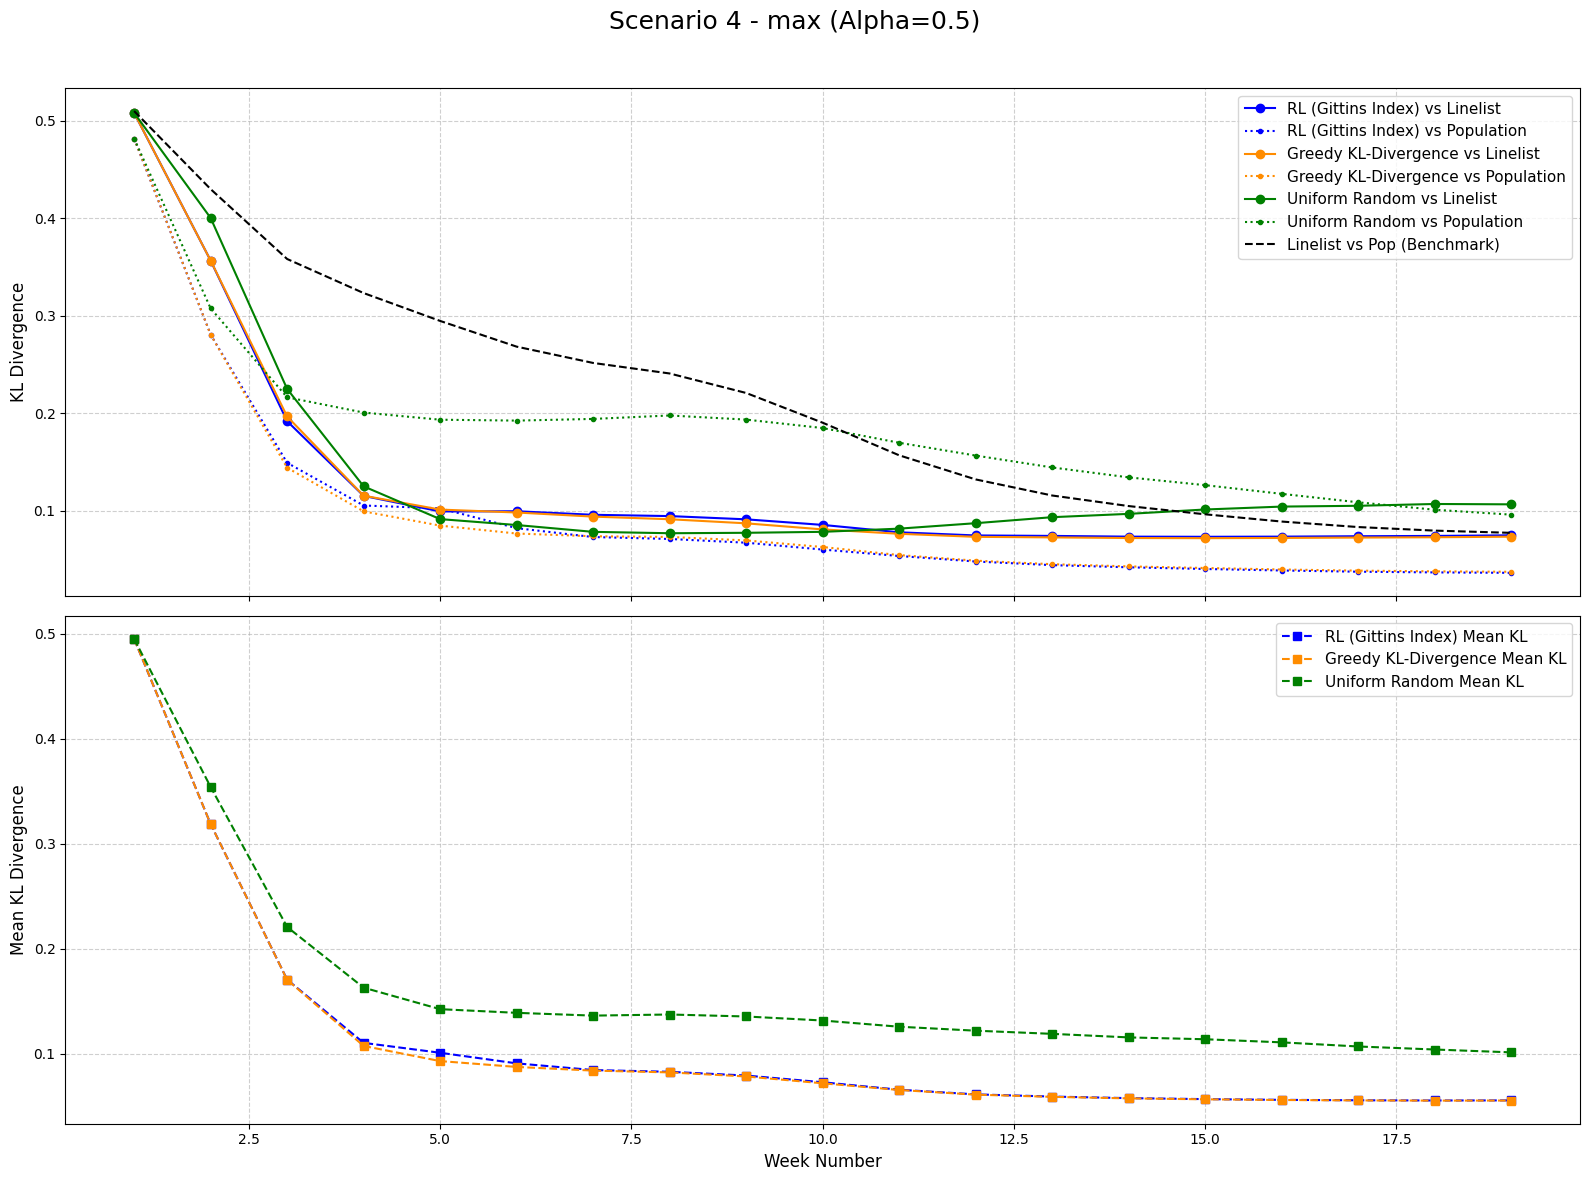

In [2]:
# -------------------------
# PLOTTING (Cumulative + Mean KL)
# -------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.suptitle(f"Scenario 4 - max (Alpha={ALPHA_WEIGHT})", fontsize=18)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

# --- ax1: KL vs Population and Linelist (Cumulative)
for name, sample_hist in results_history.items():
    cum_sample = pd.Series(dtype=float)
    cum_linelist = pd.Series(dtype=float)
    kl_pop_vals, kl_list_vals = [], []
    for i in range(len(sample_hist)):
        if i >= len(linelist_history): break
        cum_sample = cum_sample.add(sample_hist[i], fill_value=0)
        cum_linelist = cum_linelist.add(linelist_history[i], fill_value=0)
        sample_dist = cum_sample / cum_sample.sum()

        # KL vs Pop
        all_g = sample_dist.index.union(POP_DIST_STATIC.index)
        s = sample_dist.reindex(all_g, fill_value=1e-9)
        t = POP_DIST_STATIC.reindex(all_g, fill_value=1e-9)
        kl_pop_vals.append(entropy(s, t))

        # KL vs Linelist
        t2 = cum_linelist / cum_linelist.sum()
        all_g2 = sample_dist.index.union(t2.index)
        s2 = sample_dist.reindex(all_g2, fill_value=1e-9)
        t2 = t2.reindex(all_g2, fill_value=1e-9)
        kl_list_vals.append(entropy(s2, t2))

    ax1.plot(range(1, len(kl_list_vals)+1), kl_list_vals, label=f"{name} vs Linelist", linestyle='-', marker='o', color=colors[name])
    ax1.plot(range(1, len(kl_pop_vals)+1), kl_pop_vals, label=f"{name} vs Population", linestyle=':', marker='.', color=colors[name])

# KL of linelist vs population (benchmark)
cum_linelist = pd.Series(dtype=float)
benchmark_vals = []
for i in range(len(linelist_history)):
    cum_linelist = cum_linelist.add(linelist_history[i], fill_value=0)
    dist = cum_linelist / cum_linelist.sum()
    all_g = dist.index.union(POP_DIST_STATIC.index)
    s = dist.reindex(all_g, fill_value=1e-9)
    t = POP_DIST_STATIC.reindex(all_g, fill_value=1e-9)
    benchmark_vals.append(entropy(s, t))
ax1.plot(range(1, len(benchmark_vals)+1), benchmark_vals, label="Linelist vs Pop (Benchmark)", linestyle='--', color='black')

ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- ax2: Mean KL to Both Targets
for name, sample_hist in results_history.items():
    cum_sample = pd.Series(dtype=float)
    cum_linelist = pd.Series(dtype=float)
    mean_kl_vals = []
    for i in range(len(sample_hist)):
        if i >= len(linelist_history): break
        cum_sample = cum_sample.add(sample_hist[i], fill_value=0)
        cum_linelist = cum_linelist.add(linelist_history[i], fill_value=0)
        s = cum_sample / cum_sample.sum()

        all_g1 = s.index.union(POP_DIST_STATIC.index)
        s1 = s.reindex(all_g1, fill_value=1e-9)
        t1 = POP_DIST_STATIC.reindex(all_g1, fill_value=1e-9)
        kl1 = entropy(s1, t1)

        t2 = cum_linelist / cum_linelist.sum()
        all_g2 = s.index.union(t2.index)
        s2 = s.reindex(all_g2, fill_value=1e-9)
        t2 = t2.reindex(all_g2, fill_value=1e-9)
        kl2 = entropy(s2, t2)

        mean_kl_vals.append(0.5 * (kl1 + kl2))

    ax2.plot(range(1, len(mean_kl_vals)+1), mean_kl_vals, label=f"{name} Mean KL", linestyle='--', marker='s', color=colors[name])
    avg_mean_kl = np.mean(mean_kl_vals) if mean_kl_vals else float('nan')
    print(f"{name} - Average Mean KL (Population + Linelist): {avg_mean_kl:.4f}")

ax2.set_xlabel("Week Number", fontsize=12)
ax2.set_ylabel("Mean KL Divergence", fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Scenario 5

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_minimal_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_dist = pd.Series(sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index:
                    best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_groups = sampled_this_week_groups + [g]
            trial_dist = pd.Series(trial_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl:
                best_group, best_kl = g, kl
        if best_group:
            sampled_this_week_groups.append(best_group)
            group_counts[best_group] -= 1
        else:
            break
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else:
        initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0:
        return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = []
    pulls, rewards = {}, {}
    weekly_rolling_linelist_only = []

    while True:
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        rolling_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()

        # Store both the pure rolling linelist distribution and the blended target
        weekly_rolling_linelist_only.append(rolling_dist)  # <-- new list you'll define below

        target_dist = 0.5 * POP_DIST_STATIC.add(0.0, fill_value=0.0) + 0.5 * rolling_dist.add(0.0, fill_value=0.0)
        target_dist = target_dist / target_dist.sum()

        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        sampled_groups = []
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)

        weekly_sample_history.append(sample_df['group'].value_counts())
        current_week += timedelta(weeks=1)


    end_time = time.time()
    print(f"--- {name} finished in {end_time - start_time:.2f} seconds ---")
    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history,
        'rolling_linelist': weekly_rolling_linelist_only  # new entry
    }



Running Simulation for: RL (Gittins Index)
Week 2021-05-31: Pool Size = 1327, Dynamic Budget = 331
Week 2021-06-07: Pool Size = 2914, Dynamic Budget = 728
Week 2021-06-14: Pool Size = 5911, Dynamic Budget = 1000
Week 2021-06-21: Pool Size = 11498, Dynamic Budget = 1000
Week 2021-06-28: Pool Size = 21469, Dynamic Budget = 1000
Week 2021-07-05: Pool Size = 38633, Dynamic Budget = 1000
Week 2021-07-12: Pool Size = 67554, Dynamic Budget = 1000
Week 2021-07-19: Pool Size = 115799, Dynamic Budget = 1000
Week 2021-07-26: Pool Size = 187394, Dynamic Budget = 1000
Week 2021-08-02: Pool Size = 267574, Dynamic Budget = 1000
Week 2021-08-09: Pool Size = 328919, Dynamic Budget = 1000
Week 2021-08-16: Pool Size = 352831, Dynamic Budget = 1000
Week 2021-08-23: Pool Size = 348023, Dynamic Budget = 1000
Week 2021-08-30: Pool Size = 335512, Dynamic Budget = 1000
Week 2021-09-06: Pool Size = 323604, Dynamic Budget = 1000
Week 2021-09-13: Pool Size = 302729, Dynamic Budget = 1000
Week 2021-09-20: Pool Si

RL (Gittins Index) - Average KL (Rolling + Population): 0.0802
Greedy KL-Divergence - Average KL (Rolling + Population): 0.0639
Uniform Random - Average KL (Rolling + Population): 0.1952


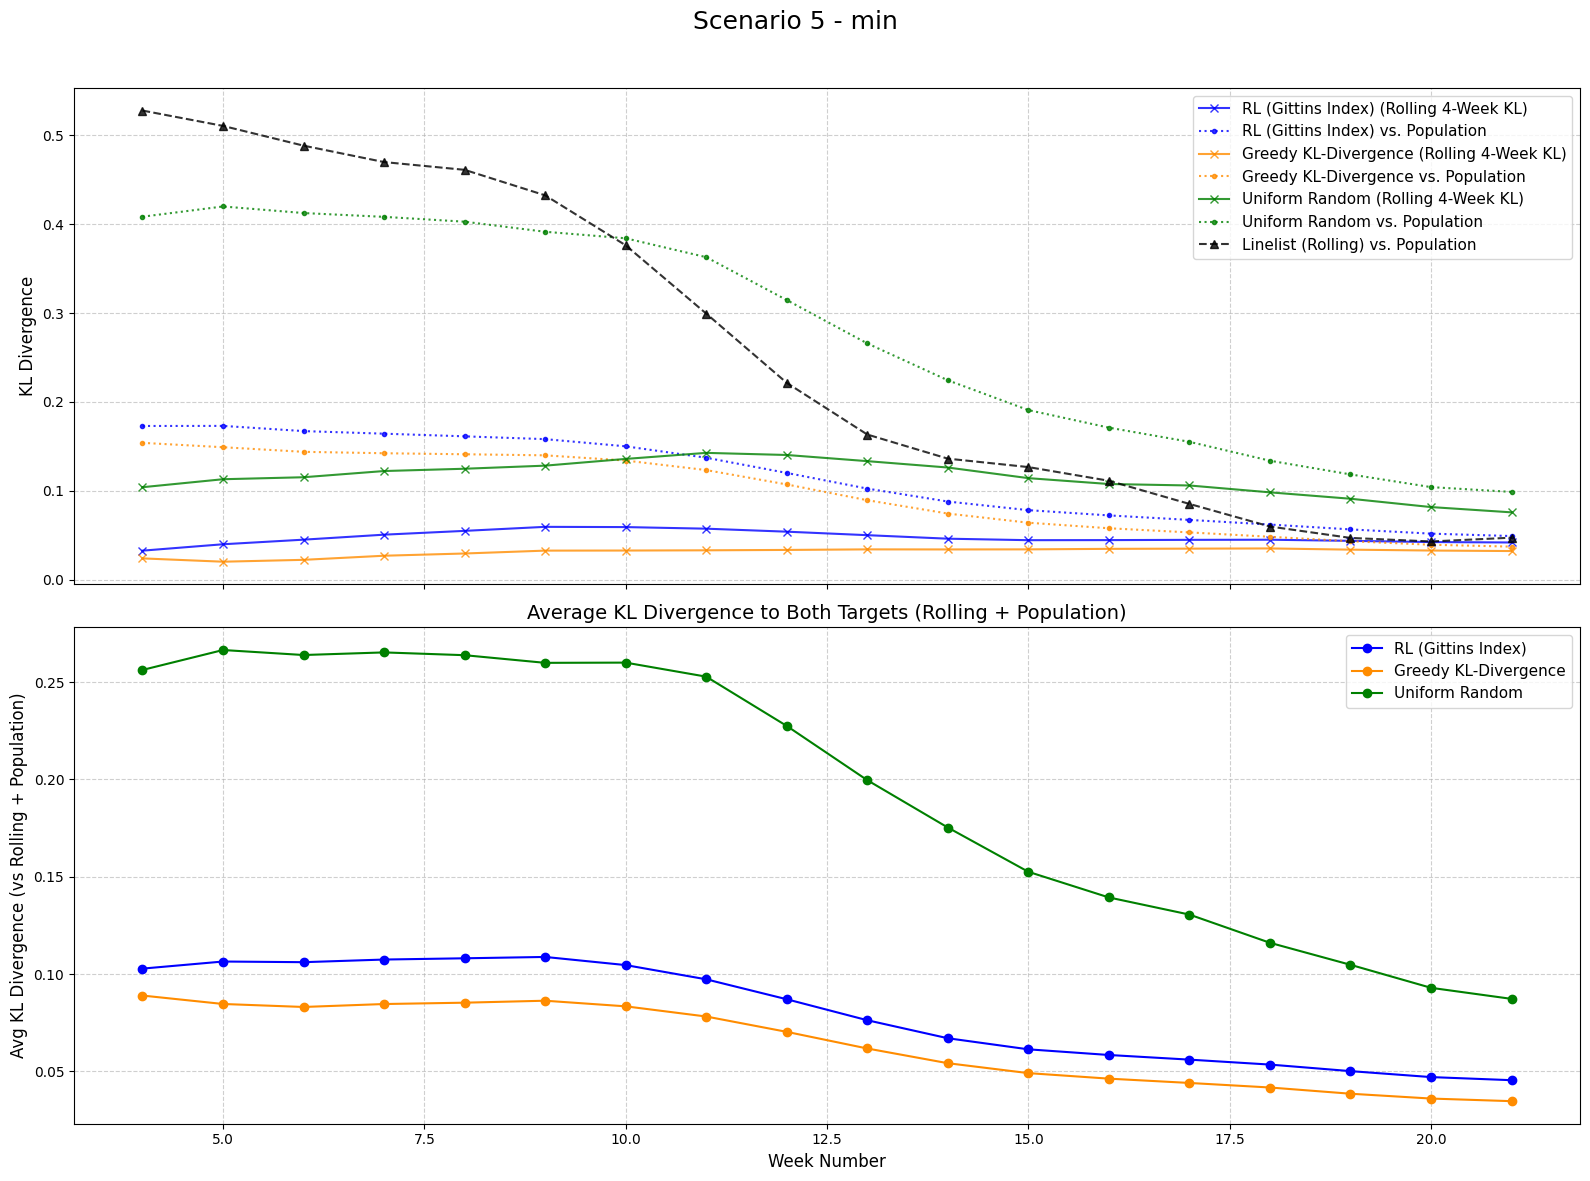

In [4]:
# -------------------------
# PLOTTING
# -------------------------
def plot_rolling_kl_vs_target(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    kl_values = []
    x_vals = []
    for i in range(3, len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break  # Target not available for this week

        rolling_samples = weekly_sample_hist[i-3:i+1]
        rolling_targets = weekly_target_dists[i]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue


        sample_dist = total_counts / total_counts.sum()

        all_groups = sample_dist.index.union(rolling_targets.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = rolling_targets.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)


def plot_rolling_kl_vs_population(ax, weekly_sample_hist, static_target_dist, label, color=None, linestyle=':'):
    """KL divergence between rolling 4-week sample and static population."""
    kl_values = []
    x_vals = []

    for i in range(3, len(weekly_sample_hist)):
        rolling_samples = weekly_sample_hist[i-3:i+1]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue

        sample_dist = total_counts / total_counts.sum()
        all_groups = sample_dist.index.union(static_target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_rolling_linelist_vs_population(ax, weekly_target_dists, static_target_dist, label, color='gray', linestyle='--'):
    """Benchmark: KL divergence between rolling linelist (weeks t-3 to t) and static population distribution."""
    kl_values = []
    for i in range(3, len(weekly_target_dists)):
        linelist_dist = weekly_target_dists[i]
        all_groups = linelist_dist.index.union(static_target_dist.index)
        s_dist = linelist_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    x_vals = list(range(4, len(weekly_target_dists) + 1))
    ax.plot(x_vals, kl_values, marker='^', linestyle=linestyle, label=label, color=color, alpha=0.8)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle("Scenario 5 - min", fontsize=18)

ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

if results_history:
    for name, history in results_history.items():
        plot_rolling_kl_vs_target(
            ax1, history['samples'], history['targets'],
            label=f"{name} (Rolling 4-Week KL)", color=colors[name], linestyle='-'
        )

        plot_rolling_kl_vs_population(
            ax1, history['samples'], POP_DIST_STATIC,
            label=f"{name} vs. Population", color=colors[name], linestyle=':'
        )

    plot_rolling_linelist_vs_population(
        ax1,
        next(iter(results_history.values()))['rolling_linelist'],
        POP_DIST_STATIC,
        label="Linelist (Rolling) vs. Population",
        color='black', linestyle='--'
    )


ax1.legend(fontsize=11)

# --- Line Chart of Mean KL Divergence to Both Targets per Week ---
ax2.set_title("Average KL Divergence to Both Targets (Rolling + Population)", fontsize=14)

for name, history in results_history.items():
    samples = history['samples']
    rolling_targets = history['targets']
    avg_kl_values = []
    x_vals = []

    for i in range(3, len(samples)):
        if i >= len(rolling_targets):
            break

        # 4-week rolling sample
        rolling_samples = samples[i-3:i+1]
        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)
        if total_counts.sum() == 0:
            continue

        sample_dist = total_counts / total_counts.sum()

        # --- KL vs rolling linelist ---
        rolling_target = rolling_targets[i]
        all_groups_rolling = sample_dist.index.union(rolling_target.index)
        s_dist_r = sample_dist.reindex(all_groups_rolling, fill_value=1e-9)
        t_dist_r = rolling_target.reindex(all_groups_rolling, fill_value=1e-9)
        kl_rolling = entropy(s_dist_r, t_dist_r)

        # --- KL vs population ---
        all_groups_pop = sample_dist.index.union(POP_DIST_STATIC.index)
        s_dist_p = sample_dist.reindex(all_groups_pop, fill_value=1e-9)
        t_dist_p = POP_DIST_STATIC.reindex(all_groups_pop, fill_value=1e-9)
        kl_pop = entropy(s_dist_p, t_dist_p)

        # --- Average ---
        avg_kl = 0.5 * (kl_rolling + kl_pop)
        avg_kl_values.append(avg_kl)
        x_vals.append(i + 1)

    ax2.plot(x_vals, avg_kl_values, label=name, linestyle='-', marker='o', color=colors[name])
    overall_avg_kl = np.mean(avg_kl_values) if avg_kl_values else float('nan')
    print(f"{name} - Average KL (Rolling + Population): {overall_avg_kl:.4f}")


ax2.set_xlabel("Week Number", fontsize=12)
ax2.set_ylabel("Avg KL Divergence (vs Rolling + Population)", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=11)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_maximum_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_dist = pd.Series(sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index:
                    best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, sampled_this_week_groups):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0:
        return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_groups = sampled_this_week_groups + [g]
            trial_dist = pd.Series(trial_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl:
                best_group, best_kl = g, kl
        if best_group:
            sampled_this_week_groups.append(best_group)
            group_counts[best_group] -= 1
        else:
            break
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else:
        initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0:
        return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = []
    pulls, rewards = {}, {}
    weekly_rolling_linelist_only = []

    while True:
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        rolling_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()

        # Store both the pure rolling linelist distribution and the blended target
        weekly_rolling_linelist_only.append(rolling_dist)  # <-- new list you'll define below

        target_dist = 0.5 * POP_DIST_STATIC.add(0.0, fill_value=0.0) + 0.5 * rolling_dist.add(0.0, fill_value=0.0)
        target_dist = target_dist / target_dist.sum()

        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Week {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        sampled_groups = []
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)

        weekly_sample_history.append(sample_df['group'].value_counts())
        current_week += timedelta(weeks=1)


    end_time = time.time()
    print(f"--- {name} finished in {end_time - start_time:.2f} seconds ---")
    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history,
        'rolling_linelist': weekly_rolling_linelist_only  # new entry
    }



Running Simulation for: RL (Gittins Index)
Week 2021-05-31: Pool Size = 588, Dynamic Budget = 147
Week 2021-06-07: Pool Size = 1378, Dynamic Budget = 344
Week 2021-06-14: Pool Size = 3002, Dynamic Budget = 750
Week 2021-06-21: Pool Size = 5880, Dynamic Budget = 1000
Week 2021-06-28: Pool Size = 10916, Dynamic Budget = 1000
Week 2021-07-05: Pool Size = 19485, Dynamic Budget = 1000
Week 2021-07-12: Pool Size = 34463, Dynamic Budget = 1000
Week 2021-07-19: Pool Size = 60311, Dynamic Budget = 1000
Week 2021-07-26: Pool Size = 99887, Dynamic Budget = 1000
Week 2021-08-02: Pool Size = 146977, Dynamic Budget = 1000
Week 2021-08-09: Pool Size = 187662, Dynamic Budget = 1000
Week 2021-08-16: Pool Size = 207740, Dynamic Budget = 1000
Week 2021-08-23: Pool Size = 208332, Dynamic Budget = 1000
Week 2021-08-30: Pool Size = 197929, Dynamic Budget = 1000
Week 2021-09-06: Pool Size = 186714, Dynamic Budget = 1000
Week 2021-09-13: Pool Size = 172986, Dynamic Budget = 1000
Week 2021-09-20: Pool Size = 

RL (Gittins Index) - Average KL (Rolling + Population): 0.0707
Greedy KL-Divergence - Average KL (Rolling + Population): 0.0480
Uniform Random - Average KL (Rolling + Population): 0.1137


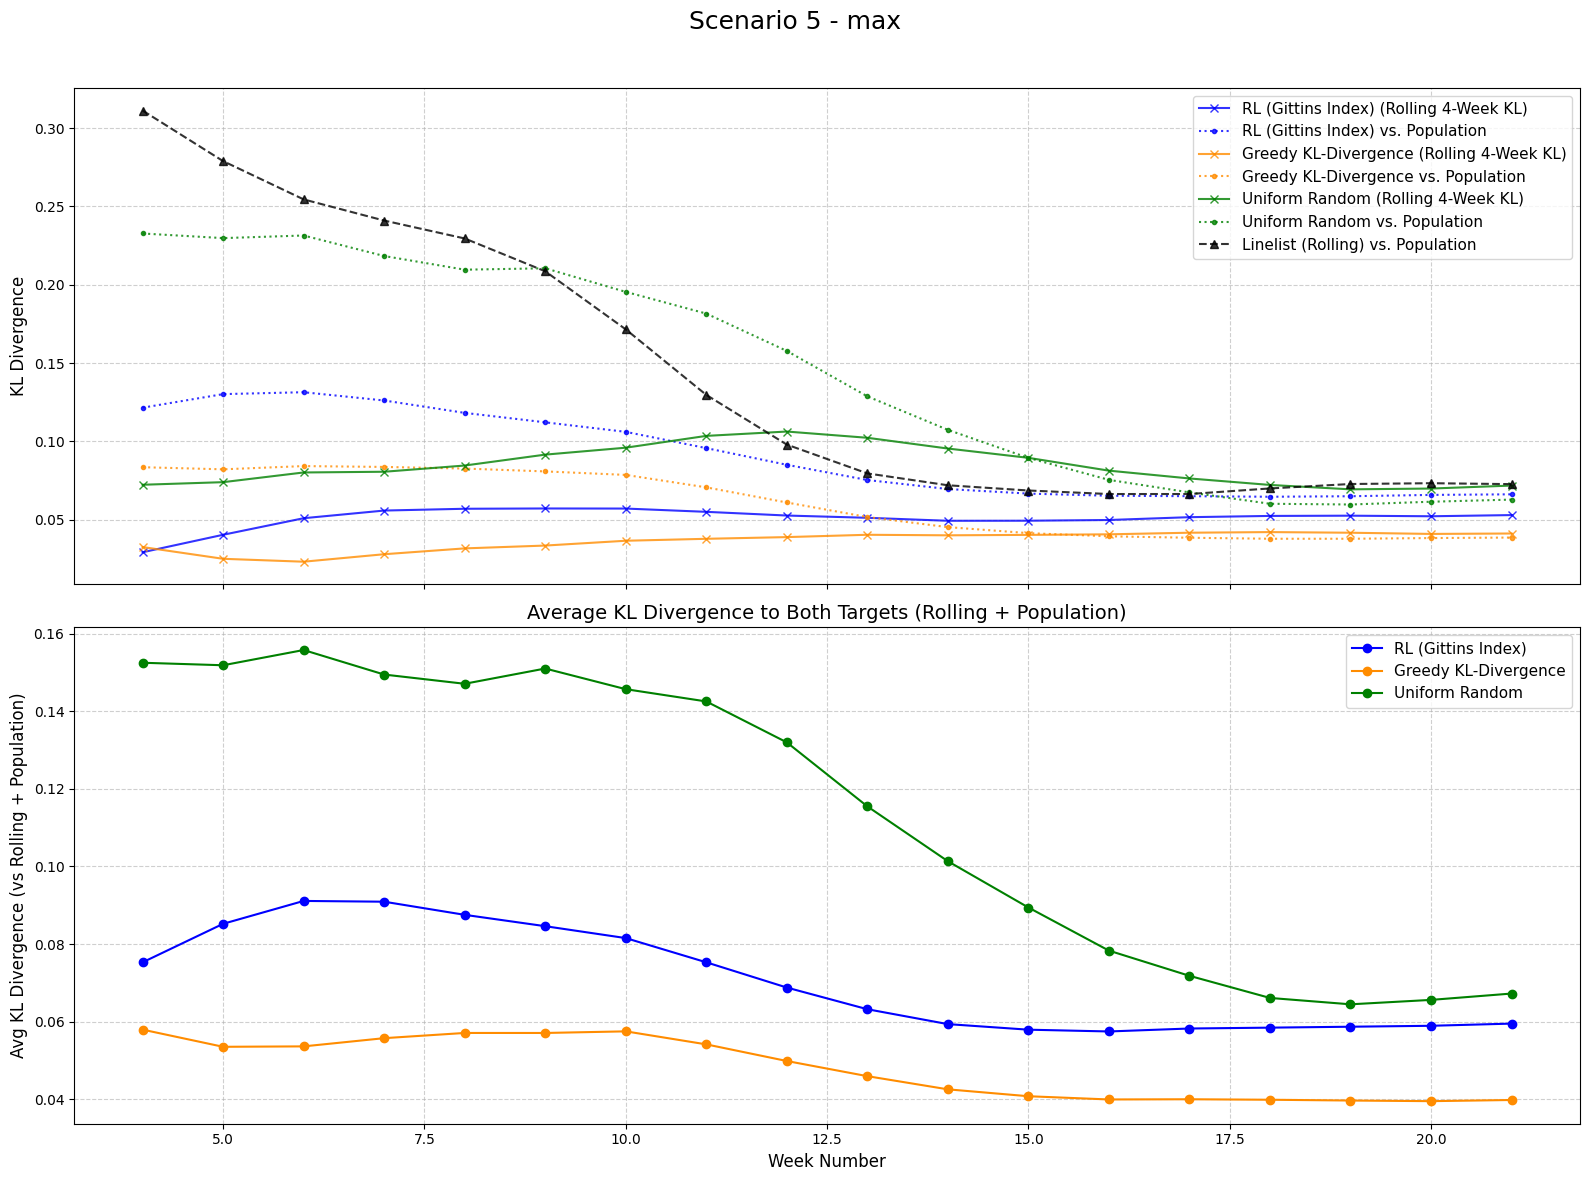

In [6]:
# -------------------------
# PLOTTING
# -------------------------
def plot_rolling_kl_vs_target(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    kl_values = []
    x_vals = []
    for i in range(3, len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break  # Target not available for this week

        rolling_samples = weekly_sample_hist[i-3:i+1]
        rolling_targets = weekly_target_dists[i]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue


        sample_dist = total_counts / total_counts.sum()

        all_groups = sample_dist.index.union(rolling_targets.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = rolling_targets.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)


def plot_rolling_kl_vs_population(ax, weekly_sample_hist, static_target_dist, label, color=None, linestyle=':'):
    """KL divergence between rolling 4-week sample and static population."""
    kl_values = []
    x_vals = []

    for i in range(3, len(weekly_sample_hist)):
        rolling_samples = weekly_sample_hist[i-3:i+1]

        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)

        if total_counts.sum() == 0:
            continue

        sample_dist = total_counts / total_counts.sum()
        all_groups = sample_dist.index.union(static_target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_rolling_linelist_vs_population(ax, weekly_target_dists, static_target_dist, label, color='gray', linestyle='--'):
    """Benchmark: KL divergence between rolling linelist (weeks t-3 to t) and static population distribution."""
    kl_values = []
    for i in range(3, len(weekly_target_dists)):
        linelist_dist = weekly_target_dists[i]
        all_groups = linelist_dist.index.union(static_target_dist.index)
        s_dist = linelist_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = static_target_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    x_vals = list(range(4, len(weekly_target_dists) + 1))
    ax.plot(x_vals, kl_values, marker='^', linestyle=linestyle, label=label, color=color, alpha=0.8)




fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle("Scenario 5 - max", fontsize=18)

ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

if results_history:
    for name, history in results_history.items():
        plot_rolling_kl_vs_target(
            ax1, history['samples'], history['targets'],
            label=f"{name} (Rolling 4-Week KL)", color=colors[name], linestyle='-'
        )

        plot_rolling_kl_vs_population(
            ax1, history['samples'], POP_DIST_STATIC,
            label=f"{name} vs. Population", color=colors[name], linestyle=':'
        )

    plot_rolling_linelist_vs_population(
        ax1,
        next(iter(results_history.values()))['rolling_linelist'],
        POP_DIST_STATIC,
        label="Linelist (Rolling) vs. Population",
        color='black', linestyle='--'
    )


ax1.legend(fontsize=11)

# --- Line Chart of Mean KL Divergence to Both Targets per Week ---
ax2.set_title("Average KL Divergence to Both Targets (Rolling + Population)", fontsize=14)

for name, history in results_history.items():
    samples = history['samples']
    rolling_targets = history['targets']
    avg_kl_values = []
    x_vals = []

    for i in range(3, len(samples)):
        if i >= len(rolling_targets):
            break

        # 4-week rolling sample
        rolling_samples = samples[i-3:i+1]
        total_counts = pd.Series(dtype=float)
        for s in rolling_samples:
            total_counts = total_counts.add(s, fill_value=0)
        if total_counts.sum() == 0:
            continue

        sample_dist = total_counts / total_counts.sum()

        # --- KL vs rolling linelist ---
        rolling_target = rolling_targets[i]
        all_groups_rolling = sample_dist.index.union(rolling_target.index)
        s_dist_r = sample_dist.reindex(all_groups_rolling, fill_value=1e-9)
        t_dist_r = rolling_target.reindex(all_groups_rolling, fill_value=1e-9)
        kl_rolling = entropy(s_dist_r, t_dist_r)

        # --- KL vs population ---
        all_groups_pop = sample_dist.index.union(POP_DIST_STATIC.index)
        s_dist_p = sample_dist.reindex(all_groups_pop, fill_value=1e-9)
        t_dist_p = POP_DIST_STATIC.reindex(all_groups_pop, fill_value=1e-9)
        kl_pop = entropy(s_dist_p, t_dist_p)

        # --- Average ---
        avg_kl = 0.5 * (kl_rolling + kl_pop)
        avg_kl_values.append(avg_kl)
        x_vals.append(i + 1)

    ax2.plot(x_vals, avg_kl_values, label=name, linestyle='-', marker='o', color=colors[name])
    overall_avg_kl = np.mean(avg_kl_values) if avg_kl_values else float('nan')
    print(f"{name} - Average KL (Rolling + Population): {overall_avg_kl:.4f}")


ax2.set_xlabel("Week Number", fontsize=12)
ax2.set_ylabel("Avg KL Divergence (vs Rolling + Population)", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=11)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Scenario 6

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_minimal_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes were needed in these functions.
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION (TARGET: ROLLING 4-WEEK WINDOW)
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = [] # Store the target distribution for each week
    weekly_rolling_linelist_history = []
    cumulative_sampled_groups = []
    pulls, rewards = {}, {}

    while True:
        # --- MODIFICATION START ---
        # Define rolling 4-week window for the pool and target
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        # Calculate the target distribution from the rolling window
        rolling_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()
        weekly_rolling_linelist_history.append(rolling_dist)

        target_dist = 0.5 * POP_DIST_STATIC.add(0.0, fill_value=0.0) + 0.5 * rolling_dist.add(0.0, fill_value=0.0)
        target_dist = target_dist / target_dist.sum()
        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Period ending {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        # Sample from the rolling window
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        # --- MODIFICATION END ---

        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        current_week += timedelta(weeks=1)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- {name} finished in {elapsed_time:.2f} seconds ---")

    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history,
        'rolling_linelist': weekly_rolling_linelist_history
    }


Running Simulation for: RL (Gittins Index)
Period ending 2021-05-31: Pool Size = 1327, Dynamic Budget = 331
Period ending 2021-06-07: Pool Size = 2914, Dynamic Budget = 728
Period ending 2021-06-14: Pool Size = 5911, Dynamic Budget = 1000
Period ending 2021-06-21: Pool Size = 11498, Dynamic Budget = 1000
Period ending 2021-06-28: Pool Size = 21469, Dynamic Budget = 1000
Period ending 2021-07-05: Pool Size = 38633, Dynamic Budget = 1000
Period ending 2021-07-12: Pool Size = 67554, Dynamic Budget = 1000
Period ending 2021-07-19: Pool Size = 115799, Dynamic Budget = 1000
Period ending 2021-07-26: Pool Size = 187394, Dynamic Budget = 1000
Period ending 2021-08-02: Pool Size = 267574, Dynamic Budget = 1000
Period ending 2021-08-09: Pool Size = 328919, Dynamic Budget = 1000
Period ending 2021-08-16: Pool Size = 352831, Dynamic Budget = 1000
Period ending 2021-08-23: Pool Size = 348023, Dynamic Budget = 1000
Period ending 2021-08-30: Pool Size = 335512, Dynamic Budget = 1000
Period ending 20

RL (Gittins Index) Mean KL - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): 0.1093
Greedy KL-Divergence Mean KL - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): 0.1302
Uniform Random Mean KL - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): 0.2295


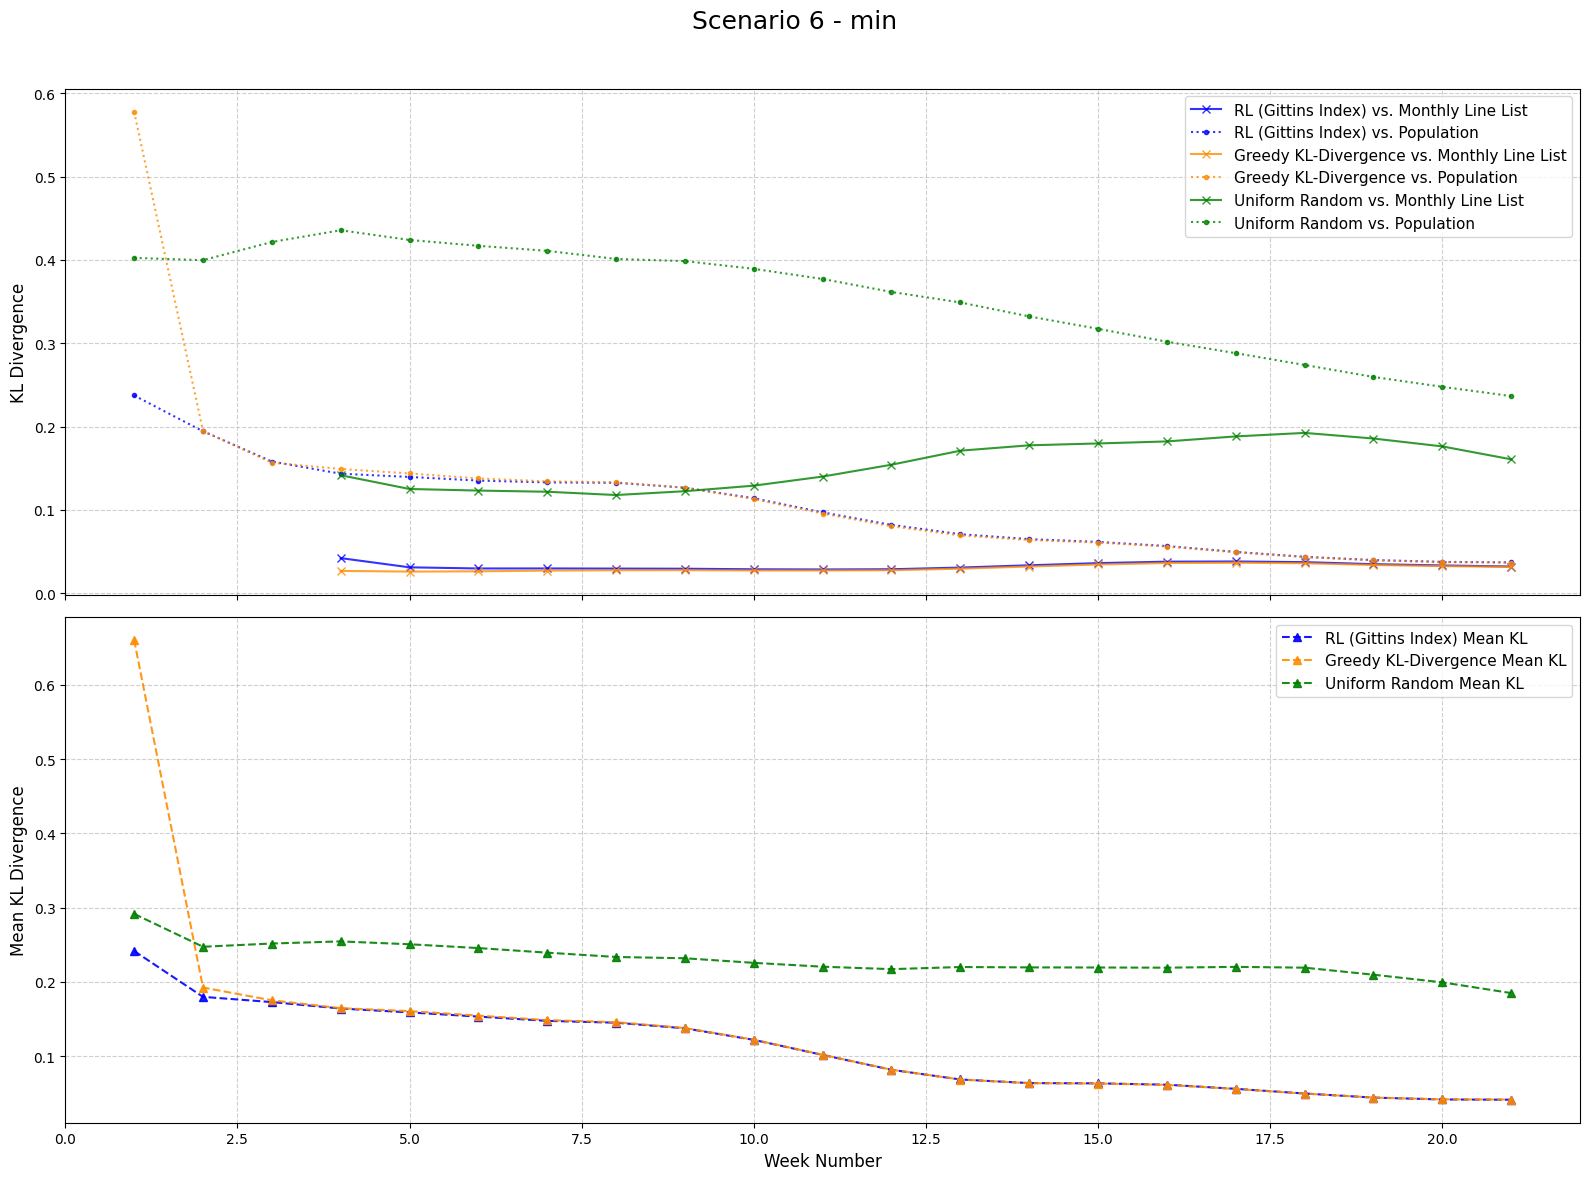

In [3]:
# -------------------------
# PLOTTING
# -------------------------

def plot_cumulative_kl_vs_rolling_target(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    """KL divergence between cumulative sample and rolling linelist target at each week."""
    kl_values = []
    x_vals = []
    cumulative_counts = pd.Series(dtype=float)

    for i in range(3, len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break  # Skip if linelist target is unavailable

        cumulative_counts = cumulative_counts.add(weekly_sample_hist[i], fill_value=0)
        rolling_target = weekly_target_dists[i]

        if cumulative_counts.sum() == 0 or rolling_target.sum() == 0:
            continue

        sample_dist = cumulative_counts / cumulative_counts.sum()
        target_dist = rolling_target / rolling_target.sum()

        all_groups = sample_dist.index.union(target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)
    return kl_values


def plot_kl_vs_static_target(ax, weekly_history, static_target_dist, label, color=None, linestyle=':'):
    """Calculates KL divergence between cumulative samples and a single static target."""
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    ax.plot(range(1, len(kl_values) + 1), kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_mean_kl_vs_both_targets(ax, weekly_sample_hist, rolling_linelist_dists, static_target_dist, label, color=None):
    """Plots the mean KL divergence between cumulative sample and both targets:
    static population and rolling linelist snapshot at each week."""
    cumulative_sample_counts = pd.Series(dtype=float)
    mean_kl_values = []
    num_weeks = min(len(weekly_sample_hist), len(rolling_linelist_dists))

    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_hist[i], fill_value=0)
        sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()

        # KL vs static population
        all_groups_pop = sample_dist.index.union(static_target_dist.index)
        s_pop = sample_dist.reindex(all_groups_pop, fill_value=1e-9)
        t_pop = static_target_dist.reindex(all_groups_pop, fill_value=1e-9)
        kl_pop = entropy(s_pop, t_pop)

        # KL vs rolling linelist snapshot
        rolling_target = rolling_linelist_dists[i]
        if rolling_target.sum() == 0:
            continue
        target_dist = rolling_target / rolling_target.sum()
        all_groups_roll = sample_dist.index.union(target_dist.index)
        s_roll = sample_dist.reindex(all_groups_roll, fill_value=1e-9)
        t_roll = target_dist.reindex(all_groups_roll, fill_value=1e-9)
        kl_roll = entropy(s_roll, t_roll)

        mean_kl = 0.5 * (kl_pop + kl_roll)
        mean_kl_values.append(mean_kl)

    ax.plot(range(1, len(mean_kl_values) + 1), mean_kl_values, marker='^', linestyle='--', label=label, color=color, alpha=0.9)
    overall_avg_kl = np.mean(mean_kl_values) if mean_kl_values else float('nan')
    print(f"{label} - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): {overall_avg_kl:.4f}")


# -------------------------
# Create Two Subplots
# -------------------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16, 12),
    sharex=True
)
fig.suptitle("Scenario 6 - min", fontsize=18)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

# --- Plot 1: KL Divergence vs Targets ---
ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

if results_history:
    for name, history in results_history.items():
        plot_cumulative_kl_vs_rolling_target(
            ax1, history['samples'], history['targets'],
            label=f"{name} vs. Monthly Line List",
            color=colors[name],
            linestyle='-'
        )
        plot_kl_vs_static_target(
            ax1, history['samples'], POP_DIST_STATIC,
            label=f"{name} vs. Population",
            color=colors[name],
            linestyle=':'
        )
ax1.legend(fontsize=11)

# --- Plot 2: Mean KL vs Both Targets ---
ax2.set_ylabel("Mean KL Divergence", fontsize=12)
ax2.set_xlabel("Week Number", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)

if results_history:
    for name, history in results_history.items():
        plot_mean_kl_vs_both_targets(
            ax2,
            history['samples'],
            history['rolling_linelist'],    # this is what was missing before
            POP_DIST_STATIC,
            label=f"{name} Mean KL",
            color=colors[name]
        )
ax2.legend(fontsize=11)

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "simulated_test_positive_linelist_maximum_bias.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE = 60
MIN_PER_GROUP = 10
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS (RL, Greedy, Uniform)
# No changes were needed in these functions.
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)

# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)
POP_DIST_STATIC = pop_df['group'].value_counts(normalize=True).sort_index()

# -------------------------
# EXPERIMENT EXECUTION (TARGET: ROLLING 4-WEEK WINDOW)
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}
results_history = {}
pool_size_history = []

for name, sampler_func in algorithms.items():
    print(f"\n{'='*20}\nRunning Simulation for: {name}\n{'='*20}")
    start_time = time.time()

    current_week = START_DATE
    weekly_sample_history = []
    weekly_target_dist_history = [] # Store the target distribution for each week
    weekly_rolling_linelist_history = []
    cumulative_sampled_groups = []
    pulls, rewards = {}, {}

    while True:
        # --- MODIFICATION START ---
        # Define rolling 4-week window for the pool and target
        start_of_window = current_week - timedelta(weeks=3)
        end_of_window = current_week
        mask = (line_df[DATE_FIELD] >= start_of_window) & (line_df[DATE_FIELD] <= end_of_window)
        rolling_pool_df = line_df[mask]

        pool_size = len(rolling_pool_df)
        if name == next(iter(algorithms)):
            pool_size_history.append(pool_size)
        if pool_size < MINIMUM_POOL_SIZE:
            print(f"Pool size for 4-week period ending {current_week.date()} is {pool_size}, stopping.")
            break

        # Calculate the target distribution from the rolling window
        rolling_dist = rolling_pool_df['group'].value_counts(normalize=True).sort_index()
        weekly_rolling_linelist_history.append(rolling_dist)

        target_dist = 0.5 * POP_DIST_STATIC.add(0.0, fill_value=0.0) + 0.5 * rolling_dist.add(0.0, fill_value=0.0)
        target_dist = target_dist / target_dist.sum()
        weekly_target_dist_history.append(target_dist)

        dynamic_batch_size = int(min(0.25 * pool_size, 1000))
        print(f"Period ending {current_week.date()}: Pool Size = {pool_size}, Dynamic Budget = {dynamic_batch_size}")

        # Sample from the rolling window
        if name == "RL (Gittins Index)":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
        elif name == "Greedy KL-Divergence":
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP, cumulative_sampled_groups)
        else:
            sample_df = sampler_func(rolling_pool_df, target_dist, dynamic_batch_size, MIN_PER_GROUP)
        # --- MODIFICATION END ---

        weekly_sample_history.append(sample_df['group'].value_counts())
        cumulative_sampled_groups.extend(sample_df['group'].tolist())
        current_week += timedelta(weeks=1)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- {name} finished in {elapsed_time:.2f} seconds ---")

    results_history[name] = {
        'samples': weekly_sample_history,
        'targets': weekly_target_dist_history,
        'rolling_linelist': weekly_rolling_linelist_history
    }


Running Simulation for: RL (Gittins Index)
Period ending 2021-05-31: Pool Size = 588, Dynamic Budget = 147
Period ending 2021-06-07: Pool Size = 1378, Dynamic Budget = 344
Period ending 2021-06-14: Pool Size = 3002, Dynamic Budget = 750
Period ending 2021-06-21: Pool Size = 5880, Dynamic Budget = 1000
Period ending 2021-06-28: Pool Size = 10916, Dynamic Budget = 1000
Period ending 2021-07-05: Pool Size = 19485, Dynamic Budget = 1000
Period ending 2021-07-12: Pool Size = 34463, Dynamic Budget = 1000
Period ending 2021-07-19: Pool Size = 60311, Dynamic Budget = 1000
Period ending 2021-07-26: Pool Size = 99887, Dynamic Budget = 1000
Period ending 2021-08-02: Pool Size = 146977, Dynamic Budget = 1000
Period ending 2021-08-09: Pool Size = 187662, Dynamic Budget = 1000
Period ending 2021-08-16: Pool Size = 207740, Dynamic Budget = 1000
Period ending 2021-08-23: Pool Size = 208332, Dynamic Budget = 1000
Period ending 2021-08-30: Pool Size = 197929, Dynamic Budget = 1000
Period ending 2021-09

RL (Gittins Index) Mean KL - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): 0.0942
Greedy KL-Divergence Mean KL - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): 0.1201
Uniform Random Mean KL - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): 0.1723


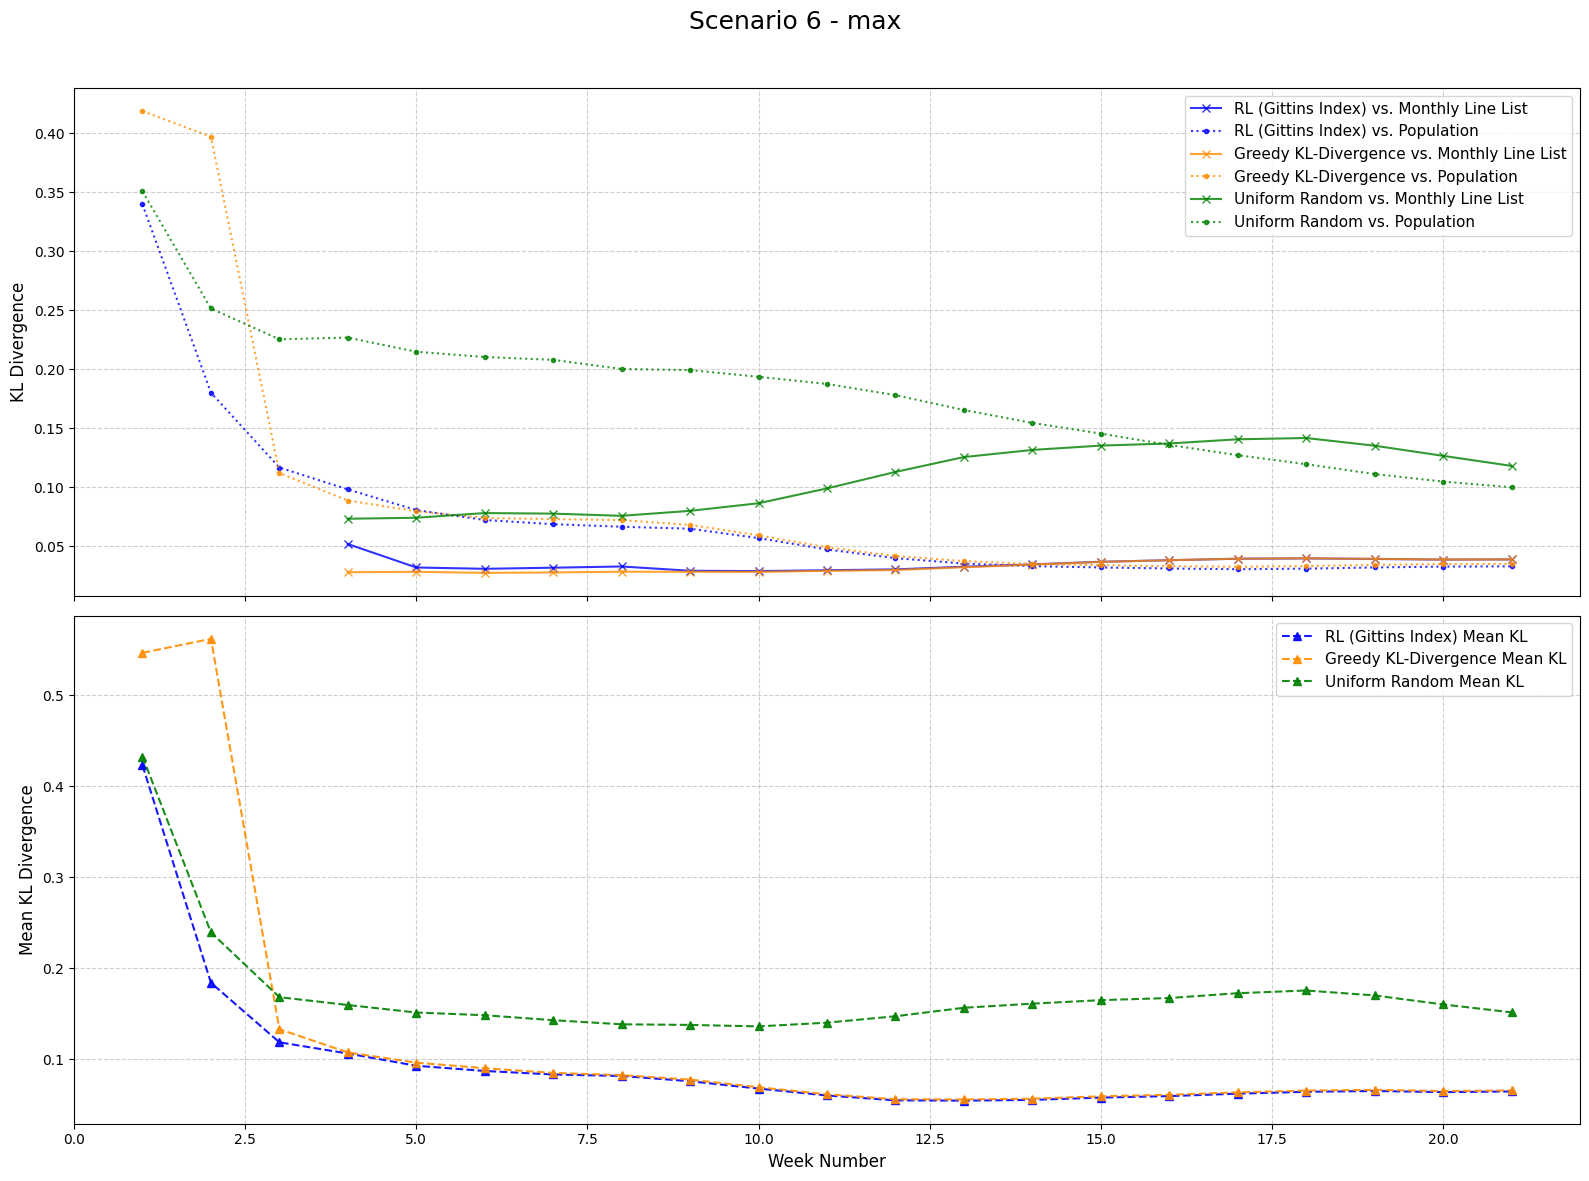

In [2]:
# -------------------------
# PLOTTING
# -------------------------

def plot_cumulative_kl_vs_rolling_target(ax, weekly_sample_hist, weekly_target_dists, label, color=None, linestyle='-'):
    """KL divergence between cumulative sample and rolling linelist target at each week."""
    kl_values = []
    x_vals = []
    cumulative_counts = pd.Series(dtype=float)

    for i in range(3, len(weekly_sample_hist)):
        if i >= len(weekly_target_dists):
            break  # Skip if linelist target is unavailable

        cumulative_counts = cumulative_counts.add(weekly_sample_hist[i], fill_value=0)
        rolling_target = weekly_target_dists[i]

        if cumulative_counts.sum() == 0 or rolling_target.sum() == 0:
            continue

        sample_dist = cumulative_counts / cumulative_counts.sum()
        target_dist = rolling_target / rolling_target.sum()

        all_groups = sample_dist.index.union(target_dist.index)
        s_dist = sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = target_dist.reindex(all_groups, fill_value=1e-9)

        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
        x_vals.append(i + 1)

    if kl_values:
        ax.plot(x_vals, kl_values, marker='x', linestyle=linestyle, label=label, color=color, alpha=0.8)
    return kl_values


def plot_kl_vs_static_target(ax, weekly_history, static_target_dist, label, color=None, linestyle=':'):
    """Calculates KL divergence between cumulative samples and a single static target."""
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    ax.plot(range(1, len(kl_values) + 1), kl_values, marker='.', linestyle=linestyle, label=label, color=color, alpha=0.8)

def plot_mean_kl_vs_both_targets(ax, weekly_sample_hist, rolling_linelist_dists, static_target_dist, label, color=None):
    """Plots the mean KL divergence between cumulative sample and both targets:
    static population and rolling linelist snapshot at each week."""
    cumulative_sample_counts = pd.Series(dtype=float)
    mean_kl_values = []
    num_weeks = min(len(weekly_sample_hist), len(rolling_linelist_dists))

    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_hist[i], fill_value=0)
        sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()

        # KL vs static population
        all_groups_pop = sample_dist.index.union(static_target_dist.index)
        s_pop = sample_dist.reindex(all_groups_pop, fill_value=1e-9)
        t_pop = static_target_dist.reindex(all_groups_pop, fill_value=1e-9)
        kl_pop = entropy(s_pop, t_pop)

        # KL vs rolling linelist snapshot
        rolling_target = rolling_linelist_dists[i]
        if rolling_target.sum() == 0:
            continue
        target_dist = rolling_target / rolling_target.sum()
        all_groups_roll = sample_dist.index.union(target_dist.index)
        s_roll = sample_dist.reindex(all_groups_roll, fill_value=1e-9)
        t_roll = target_dist.reindex(all_groups_roll, fill_value=1e-9)
        kl_roll = entropy(s_roll, t_roll)

        mean_kl = 0.5 * (kl_pop + kl_roll)
        mean_kl_values.append(mean_kl)

    ax.plot(range(1, len(mean_kl_values) + 1), mean_kl_values, marker='^', linestyle='--', label=label, color=color, alpha=0.9)
    overall_avg_kl = np.mean(mean_kl_values) if mean_kl_values else float('nan')
    print(f"{label} - Average Mean KL (Cumulative vs. Pop + Rolling Linelist): {overall_avg_kl:.4f}")


# -------------------------
# Create Two Subplots
# -------------------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16, 12),
    sharex=True
)
fig.suptitle("Scenario 6 - max", fontsize=18)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

# --- Plot 1: KL Divergence vs Targets ---
ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

if results_history:
    for name, history in results_history.items():
        plot_cumulative_kl_vs_rolling_target(
            ax1, history['samples'], history['targets'],
            label=f"{name} vs. Monthly Line List",
            color=colors[name],
            linestyle='-'
        )
        plot_kl_vs_static_target(
            ax1, history['samples'], POP_DIST_STATIC,
            label=f"{name} vs. Population",
            color=colors[name],
            linestyle=':'
        )
ax1.legend(fontsize=11)

# --- Plot 2: Mean KL vs Both Targets ---
ax2.set_ylabel("Mean KL Divergence", fontsize=12)
ax2.set_xlabel("Week Number", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)

if results_history:
    for name, history in results_history.items():
        plot_mean_kl_vs_both_targets(
            ax2,
            history['samples'],
            history['rolling_linelist'],    # this is what was missing before
            POP_DIST_STATIC,
            label=f"{name} Mean KL",
            color=colors[name]
        )
ax2.legend(fontsize=11)

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


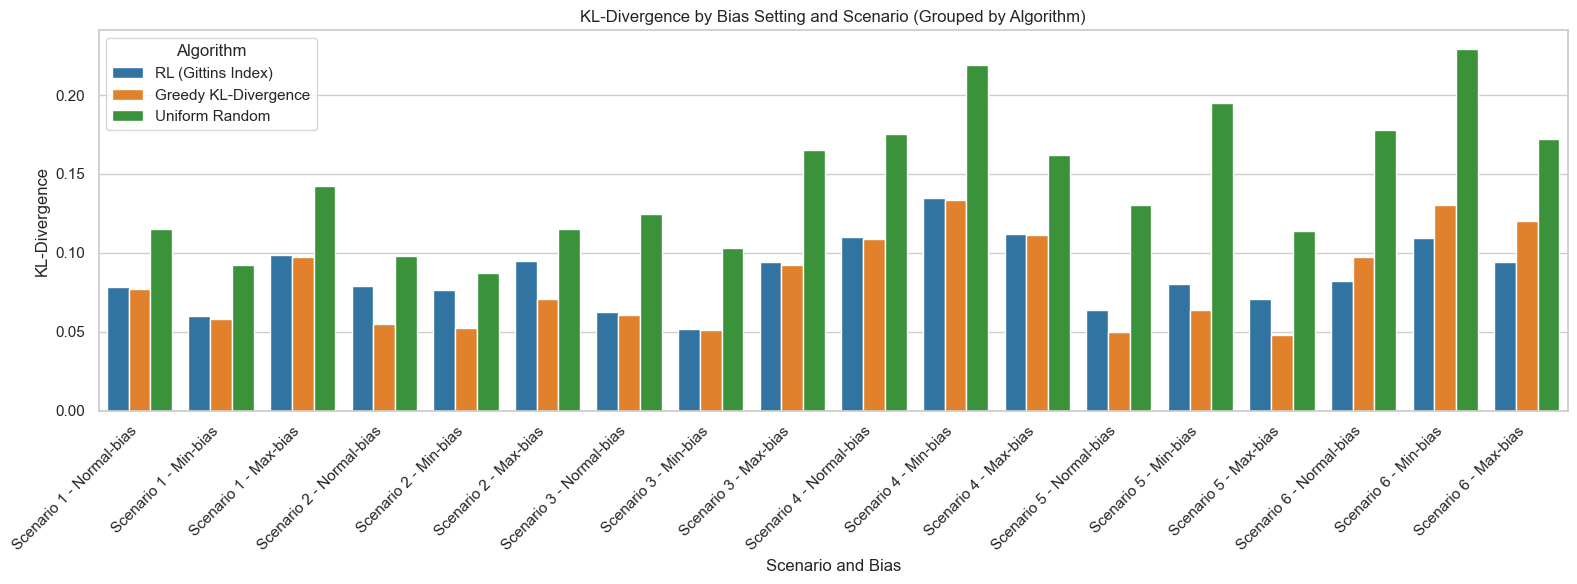

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Raw data setup (same as before)
bias_types = ["Normal-bias", "Min-bias", "Max-bias"]
algorithms = ["RL (Gittins Index)", "Greedy KL-Divergence", "Uniform Random"]

kl_data = {
    1: {
        "RL (Gittins Index)": [0.0783, 0.0598, 0.0989],
        "Greedy KL-Divergence": [0.0772, 0.0581, 0.0976],
        "Uniform Random": [0.1153, 0.0920, 0.1423],
    },
    2: {
        "RL (Gittins Index)": [0.0791, 0.0767, 0.0949],
        "Greedy KL-Divergence": [0.0549, 0.0522, 0.0708],
        "Uniform Random": [0.0981, 0.0871, 0.1150],
    },
    3: {
        "RL (Gittins Index)": [0.0623, 0.0520, 0.0942],
        "Greedy KL-Divergence": [0.0609, 0.0511, 0.0924],
        "Uniform Random": [0.1246, 0.1029, 0.1655],
    },
    4: {
        "RL (Gittins Index)": [0.1101, 0.1347, 0.1121],
        "Greedy KL-Divergence": [0.1091, 0.1336, 0.1111],
        "Uniform Random": [0.1755, 0.2191, 0.1618],
    },
    5: {
        "RL (Gittins Index)": [0.0637, 0.0802, 0.0707],
        "Greedy KL-Divergence": [0.0500, 0.0639, 0.0480],
        "Uniform Random": [0.1304, 0.1952, 0.1137],
    },
    6: {
        "RL (Gittins Index)": [0.0822, 0.1093, 0.0942],
        "Greedy KL-Divergence": [0.0976, 0.1302, 0.1201],
        "Uniform Random": [0.1778, 0.2295, 0.1723],
    },
}

# Build dataframe
records = []
for scenario, alg_dict in kl_data.items():
    for algorithm, kl_values in alg_dict.items():
        for bias, kl in zip(bias_types, kl_values):
            records.append({
                "Scenario": f"Scenario {scenario}",
                "Bias": bias,
                "Algorithm": algorithm,
                "KL-Divergence": kl,
                "XLabel": f"Scenario {scenario} - {bias}"
            })

df = pd.DataFrame(records)

# Define custom color palette
custom_palette = {
    "RL (Gittins Index)": "#1f77b4",     # Blue
    "Greedy KL-Divergence": "#ff7f0e",   # Orange
    "Uniform Random": "#2ca02c"          # Green
}

# Plot
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

sns.barplot(
    data=df,
    x="XLabel",
    y="KL-Divergence",
    hue="Algorithm",
    palette=custom_palette
)

# Styling
plt.xticks(rotation=45, ha="right")
plt.title("KL-Divergence by Bias Setting and Scenario (Grouped by Algorithm)")
plt.xlabel("Scenario and Bias")
plt.ylabel("KL-Divergence")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()
